# **Task 1 : AE vs VAE for Compression**

# **1)Auto-Encoder**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#imports
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Subset
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
#Device
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"current device:{device}")

current device:cuda


In [6]:
#hyperparams
batch_size=128
lr=1e-3
epochs=20
latent_dim=128 #bottleneck size (which is the compression level)

In [7]:
transform=transforms.ToTensor()

#load datasets
train_dataset=datasets.FashionMNIST(root="./data",train=True,download=True,transform=transform)
test_dataset=datasets.FashionMNIST(root="./data",train=False,download=True,transform=transform)

#only first 10k samples
train_dataset=Subset(train_dataset,range(10000))

#Dataloaders
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# **Convolutional Auto-Encoder**

1. i'm going to use Convolutional AE unlike FC AE
2. to preserve the spatial structure of images through shared weights and local connections



---

 ### **for the architecture used:**



*   deep architecture of 4 encoder blocks and 4 decoder blocks
*   each block in encoder is:2 simple convolution each one followed by batch normalization+ReLU activation and at the end a max pooling layer
=>downsampling: 28=>14=>7=>3=>1



*  each block in decoder is:transposed convolution to restore the size of the image progressively and a simple convolution ,each one followed by batch normalization+ReLU activation
=>upsampling: 1=>3=>7=>14=>28










In [8]:
class ConvAutoEncoder(nn.Module):
  def __init__(self,latent_dim):
    super(ConvAutoEncoder,self).__init__()

    #Encoder unit (downsampling by factor of 2)
    # Input: 1x28x28
    self.encoder = nn.Sequential(
        # Block 1: 28x28 -> 14x14
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),  # 14x14

        # Block 2: 14x14 -> 7x7
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),  # 7x7

        # Block 3: 7x7 -> 3x3
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),  # 3x3

        # Block 4: 3x3 -> 1x1
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 3),  # 1x1
    )

    # Bottleneck part
    self.flatten = nn.Flatten()
    self.fc_encoder = nn.Sequential(
        nn.Linear(512 * 1 * 1, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, latent_dim)
    )

      # Decoder bottleneck
    self.fc_decoder = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512 * 1 * 1),
        nn.ReLU(inplace=True)
    )
    self.unflatten = nn.Unflatten(1, (512, 1, 1))

    # Decoder,Progressive upsampling to 28x28
    self.decoder = nn.Sequential(
        # Block 1: 1x1 -> 3x3
        nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),  # 3x3
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        # Block 2: 3x3 -> 7x7
        nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=0),  # 7x7
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        # Block 3: 7x7 -> 14x14
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        # Block 4: 14x14 -> 28x28
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),

        # Final layer: 28x28 -> 28x28
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def encode(self, x):
      x = self.encoder(x)
      x = self.flatten(x)
      x = self.fc_encoder(x)
      return x

  def decode(self, z):
      x = self.fc_decoder(z)
      x = self.unflatten(x)
      x = self.decoder(x)
      return x

  def forward(self, x):
      z = self.encode(x)
      x_recon = self.decode(z)
      return x_recon, z

In [92]:
def train_autoencoder(model, train_loader, test_loader, epochs, lr, device):
    model = model.to(device)

    # Loss function  MSE for reconstruction
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    history = {
        'train_loss': [],
        'test_loss': []
    }

    for epoch in range(epochs):
       #training phase
        model.train()
        train_loss = 0.0
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (images, _) in enumerate(train_pbar):
            images = images.to(device)

            # Forward pass
            reconstructed, latent = model(images)

            # Compute loss
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

        # Average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation Phase
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')

            for images, _ in test_pbar:
                images = images.to(device)

                # Forward pass
                reconstructed, latent = model(images)

                # Compute loss
                loss = criterion(reconstructed, images)
                test_loss += loss.item()

                # Update progress bar
                test_pbar.set_postfix({'loss': loss.item()})

        # Average test loss
        avg_test_loss = test_loss / len(test_loader)
        history['test_loss'].append(avg_test_loss)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}] - '
              f'Train Loss: {avg_train_loss:.6f}, '
              f'Test Loss: {avg_test_loss:.6f}')

    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model
model = ConvAutoEncoder(latent_dim=latent_dim)

# Train the model
history = train_autoencoder(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=epochs,
    lr=lr,
    device=device
)

Using device: cuda


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.46it/s, loss=0.0695]


Epoch [1/20] - Train Loss: 0.065267, Test Loss: 0.061052


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.48it/s, loss=0.0979]


Epoch [2/20] - Train Loss: 0.052249, Test Loss: 0.077389


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.31it/s, loss=0.0644]


Epoch [3/20] - Train Loss: 0.051036, Test Loss: 0.055904


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s, loss=0.067]


Epoch [4/20] - Train Loss: 0.047489, Test Loss: 0.056533


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:04<00:00, 19.49it/s, loss=0.0537]


Epoch [5/20] - Train Loss: 0.044236, Test Loss: 0.040555


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.03it/s, loss=0.0577]


Epoch [6/20] - Train Loss: 0.040177, Test Loss: 0.043989


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.99it/s, loss=0.049]


Epoch [7/20] - Train Loss: 0.037628, Test Loss: 0.041861


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.33it/s, loss=0.0474]


Epoch [8/20] - Train Loss: 0.037104, Test Loss: 0.038761


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.31it/s, loss=0.0425]


Epoch [9/20] - Train Loss: 0.035887, Test Loss: 0.036203


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.36it/s, loss=0.0421]


Epoch [10/20] - Train Loss: 0.034901, Test Loss: 0.033360


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.28it/s, loss=0.0428]


Epoch [11/20] - Train Loss: 0.034020, Test Loss: 0.035530


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s, loss=0.0403]


Epoch [12/20] - Train Loss: 0.033768, Test Loss: 0.032460


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s, loss=0.0416]


Epoch [13/20] - Train Loss: 0.033866, Test Loss: 0.031610


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.0389]


Epoch [14/20] - Train Loss: 0.032109, Test Loss: 0.031617


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.38it/s, loss=0.0469]


Epoch [15/20] - Train Loss: 0.033076, Test Loss: 0.035170


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s, loss=0.037]


Epoch [16/20] - Train Loss: 0.032222, Test Loss: 0.032140


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.14it/s, loss=0.0399]


Epoch [17/20] - Train Loss: 0.031956, Test Loss: 0.031127


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s, loss=0.0367]


Epoch [18/20] - Train Loss: 0.031555, Test Loss: 0.031449


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s, loss=0.0369]


Epoch [19/20] - Train Loss: 0.031292, Test Loss: 0.031022


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.75it/s, loss=0.0384]

Epoch [20/20] - Train Loss: 0.031073, Test Loss: 0.032167


In [94]:
import os
drive_dir = "/content/drive/MyDrive/Computer Vision/assignment1/models"
ae_path = os.path.join(drive_dir, "conv_ae_latent128.pth")
torch.save({
    "model_state_dict": model.state_dict(),
    "latent_dim": 128,
    "epoch":epochs
}, ae_path)

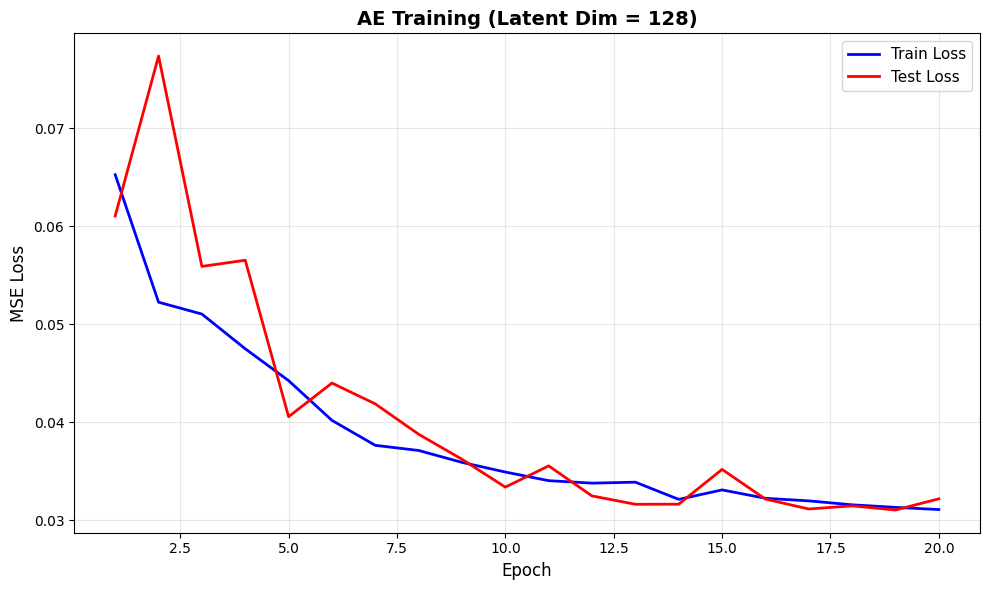

In [95]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title='Autoencoder Training'):
    #Plot training and test loss curves
    plt.figure(figsize=(10, 6))

    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['test_loss'], 'r-', label='Test Loss', linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(history, title=f'AE Training (Latent Dim = {latent_dim})')

#**2)Variational Auto-Encoder**



1.   I'll reuse the same architecture as Conv-AE for fair comparaison
2.   instead of fc_encode, i'll output: mean and log variance



In [9]:
class ConvVAE(nn.Module):
  def __init__(self,latent_dim):
    super(ConvVAE,self).__init__()

    #Encoder unit (downsampling by factor of 2)
    self.encoder = nn.Sequential(
            # Block 1: 28x28 -> 14x14
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 14x14

            # Block 2: 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 7x7

            # Block 3: 7x7 -> 3x3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 3x3

            # Block 4: 3x3 -> 1x1
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 3),  # 1x1
        )

    # Flatten
    self.flatten = nn.Flatten()

    # Encoder output: mu and logvar
    self.fc_shared = nn.Sequential(
        nn.Linear(512 * 1 * 1, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2)
    )

    # Separate heads for mean (mu) and log-variance (logvar)
    self.fc_mu = nn.Linear(1024, latent_dim)
    self.fc_logvar = nn.Linear(1024, latent_dim)

    # Decoder input
    self.fc_decoder = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512 * 1 * 1),
        nn.ReLU(inplace=True)
    )
    self.unflatten = nn.Unflatten(1, (512, 1, 1))

    # Decoder,Progressive upsampling to 28x28
    self.decoder = nn.Sequential(
        # Block 1: 1x1 -> 3x3
        nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),  # 3x3
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        # Block 2: 3x3 -> 7x7
        nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=0),  # 7x7
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        # Block 3: 7x7 -> 14x14
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        # Block 4: 14x14 -> 28x28
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),

        # Final layer: 28x28 -> 28x28
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()  # Output in [0, 1] range
    )

  def encode(self, x):
      x = self.encoder(x)
      x = self.flatten(x)
      x = self.fc_shared(x)
      mu = self.fc_mu(x)
      logvar = self.fc_logvar(x)
      return mu, logvar

  def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

  def decode(self, z):
      #Decode latent variable to reconstruction
      x = self.fc_decoder(z)
      x = self.unflatten(x)
      x = self.decoder(x)
      return x

  def forward(self, x):
      #Full forward pass
      mu, logvar = self.encode(x)
      z = self.reparameterize(mu, logvar)
      x_recon = self.decode(z)
      return x_recon, mu, logvar

In [97]:
#VAE loss (recons+KL)
def vae_loss(recons_x,x,mu,logvar):
  recons_loss=nn.functional.mse_loss(recons_x,x,reduction='sum')
  kl_loss=-0.5 * torch.sum(1+logvar-mu.pow(2)-logvar.exp())
  return recons_loss+kl_loss

In [99]:
def train_vae(model, train_loader, test_loader, epochs, lr, device):
    model1 = model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    history = {
        'train_loss': [],
        'test_loss': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for batch_idx, (images, _) in enumerate(train_pbar):
            images = images.to(device)

            # Forward pass
            reconstructed, mu, logvar = model(images)

            # Compute VAE loss
            loss = vae_loss(reconstructed, images, mu, logvar)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

        # Average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')

            for images, _ in test_pbar:
                images = images.to(device)

                # Forward pass
                reconstructed, mu, logvar = model(images)

                # Compute VAE loss
                loss = vae_loss(reconstructed, images, mu, logvar)
                test_loss += loss.item()

                # Update progress bar
                test_pbar.set_postfix({'loss': loss.item()})

        # Average test loss
        avg_test_loss = test_loss / len(test_loader)
        history['test_loss'].append(avg_test_loss)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}] - '
              f'Train Loss: {avg_train_loss:.2f}, '
              f'Test Loss: {avg_test_loss:.2f}')

    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize VAE model
vae_model = ConvVAE(latent_dim=latent_dim).to(device)

# Train the VAE
vae_history = train_vae(
    model=vae_model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=epochs,
    lr=lr,
    device=device
)

Using device: cuda


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 21.17it/s, loss=1.01e+3]


Epoch [1/20] - Train Loss: 7871.68, Test Loss: 6953.82


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.96it/s, loss=945]


Epoch [2/20] - Train Loss: 6806.39, Test Loss: 6504.89


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s, loss=1.02e+3]


Epoch [3/20] - Train Loss: 6603.85, Test Loss: 6467.24


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.25it/s, loss=978]


Epoch [4/20] - Train Loss: 6141.93, Test Loss: 6067.67


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.41it/s, loss=900]


Epoch [5/20] - Train Loss: 5777.93, Test Loss: 5533.77


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s, loss=860]


Epoch [6/20] - Train Loss: 5542.16, Test Loss: 5350.18


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s, loss=833]


Epoch [7/20] - Train Loss: 5483.65, Test Loss: 5205.00


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.89it/s, loss=791]


Epoch [8/20] - Train Loss: 5364.44, Test Loss: 5086.55


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.25it/s, loss=844]


Epoch [9/20] - Train Loss: 5303.17, Test Loss: 5132.98


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.06it/s, loss=815]


Epoch [10/20] - Train Loss: 5137.47, Test Loss: 5075.08


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s, loss=808]


Epoch [11/20] - Train Loss: 5112.92, Test Loss: 4797.43


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.44it/s, loss=858]


Epoch [12/20] - Train Loss: 5101.06, Test Loss: 5312.15


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.20it/s, loss=786]


Epoch [13/20] - Train Loss: 5072.15, Test Loss: 4793.51


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.86it/s, loss=750]


Epoch [14/20] - Train Loss: 5114.82, Test Loss: 4775.58


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.23it/s, loss=763]


Epoch [15/20] - Train Loss: 5042.24, Test Loss: 4870.09


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.34it/s, loss=771]


Epoch [16/20] - Train Loss: 4997.83, Test Loss: 4691.57


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.15it/s, loss=760]


Epoch [17/20] - Train Loss: 4941.02, Test Loss: 4718.92


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s, loss=764]


Epoch [18/20] - Train Loss: 4883.38, Test Loss: 4693.49


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.06it/s, loss=722]


Epoch [19/20] - Train Loss: 4931.78, Test Loss: 4699.64


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.60it/s, loss=800]

Epoch [20/20] - Train Loss: 4837.63, Test Loss: 5082.83


In [101]:
import os
drive_dir = "/content/drive/MyDrive/Computer Vision/assignment1/models"
vae_path = os.path.join(drive_dir, "conv_vae_latent128.pth")
torch.save({
    "model_state_dict": model1.state_dict(),
    "latent_dim": 32,
    "epoch":epochs
}, vae_path)

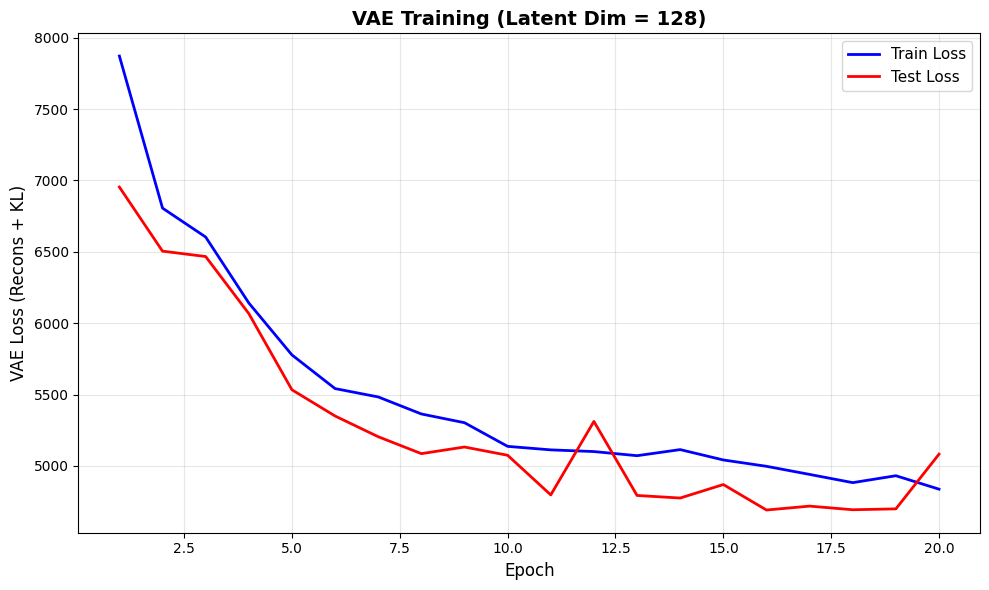

In [102]:
def plot_training_curves(history, title='VAE Training'):
    #Plot training and test loss curves
    plt.figure(figsize=(10, 6))

    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['test_loss'], 'r-', label='Test Loss', linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('VAE Loss (Recons + KL)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(vae_history, title=f'VAE Training (Latent Dim = {latent_dim})')

# **3) for the part 3:i already train each model directly under their architecture**

# **4) Comparaison for reconstruction quality for different latent spaces**

In [103]:
latent_dims = [2, 8, 16, 32, 64]

In [104]:
# Train both AE and VAE for different latent dimensions
ae_models = {}
vae_models = {}
ae_histories = {}
vae_histories = {}

for latent_dim in latent_dims:
    print(f"Training models with latent_dim = {latent_dim}")

    # Train Autoencoder
    print(f"Training Autoencoder")
    ae_model = ConvAutoEncoder(latent_dim=latent_dim).to(device)
    ae_optimizer = optim.Adam(ae_model.parameters(), lr=lr)

    ae_history = train_autoencoder(ae_model, train_loader, test_loader, epochs, lr, device)

    # Save AE
    drive_dir = "/content/drive/MyDrive/Computer Vision/assignment1/models"
    ae_path = os.path.join(drive_dir, f"conv_ae_latent{latent_dim}.pth")
    torch.save({
        "model_state_dict": ae_model.state_dict(),
        "optimizer_state_dict": ae_optimizer.state_dict(),
        "latent_dim": latent_dim,
        "epoch": epochs,
        "train_loss": ae_history['train_loss'],
        "test_loss": ae_history['test_loss']
    }, ae_path)

    ae_models[latent_dim] = ae_model
    ae_histories[latent_dim] = ae_history
    print(f"AE saved: {ae_path}\n")

    #Train VAE
    print(f" Training VAE")
    vae_model = ConvVAE(latent_dim=latent_dim).to(device)
    vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)

    vae_history = train_vae(vae_model, train_loader, test_loader, epochs, lr, device)

    # Save VAE
    vae_path = os.path.join(drive_dir, f"conv_vae_latent{latent_dim}.pth")
    torch.save({
        "model_state_dict": vae_model.state_dict(),
        "optimizer_state_dict": vae_optimizer.state_dict(),
        "latent_dim": latent_dim,
        "epoch": epochs,
        "train_loss": vae_history['train_loss'],
        "test_loss": vae_history['test_loss']
    }, vae_path)

    vae_models[latent_dim] = vae_model
    vae_histories[latent_dim] = vae_history
    print(f"VAE saved: {vae_path}\n")

print("All models trained successfully!")


Training models with latent_dim = 2
Training Autoencoder


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.01it/s, loss=0.0625]


Epoch [1/20] - Train Loss: 0.066818, Test Loss: 0.053243


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 20.25it/s, loss=0.0738]


Epoch [2/20] - Train Loss: 0.052568, Test Loss: 0.062202


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.64it/s, loss=0.057]


Epoch [3/20] - Train Loss: 0.050298, Test Loss: 0.048203


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s, loss=0.0536]


Epoch [4/20] - Train Loss: 0.045941, Test Loss: 0.044953


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 19.90it/s, loss=0.0473]


Epoch [5/20] - Train Loss: 0.039822, Test Loss: 0.040562


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s, loss=0.0456]


Epoch [6/20] - Train Loss: 0.037681, Test Loss: 0.036733


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=0.0426]


Epoch [7/20] - Train Loss: 0.035337, Test Loss: 0.033919


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.77it/s, loss=0.0438]


Epoch [8/20] - Train Loss: 0.033986, Test Loss: 0.036881


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.84it/s, loss=0.0408]


Epoch [9/20] - Train Loss: 0.033966, Test Loss: 0.032366


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.74it/s, loss=0.0419]


Epoch [10/20] - Train Loss: 0.033302, Test Loss: 0.033154


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s, loss=0.0405]


Epoch [11/20] - Train Loss: 0.032998, Test Loss: 0.033063


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.70it/s, loss=0.0401]


Epoch [12/20] - Train Loss: 0.032706, Test Loss: 0.033266


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.52it/s, loss=0.0386]


Epoch [13/20] - Train Loss: 0.031488, Test Loss: 0.031057


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.95it/s, loss=0.0382]


Epoch [14/20] - Train Loss: 0.031105, Test Loss: 0.031368


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.65it/s, loss=0.0382]


Epoch [15/20] - Train Loss: 0.031432, Test Loss: 0.033317


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.62it/s, loss=0.0374]


Epoch [16/20] - Train Loss: 0.031115, Test Loss: 0.031641


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s, loss=0.0382]


Epoch [17/20] - Train Loss: 0.030655, Test Loss: 0.030707


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.17it/s, loss=0.0378]


Epoch [18/20] - Train Loss: 0.030247, Test Loss: 0.032715


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.02it/s, loss=0.0372]


Epoch [19/20] - Train Loss: 0.030313, Test Loss: 0.029103


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s, loss=0.0354]


Epoch [20/20] - Train Loss: 0.029820, Test Loss: 0.029249
AE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent2.pth

 Training VAE


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.16it/s, loss=927]


Epoch [1/20] - Train Loss: 6979.35, Test Loss: 6541.46


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.94it/s, loss=1.06e+3]


Epoch [2/20] - Train Loss: 5746.22, Test Loss: 8071.58


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.72it/s, loss=841]


Epoch [3/20] - Train Loss: 5508.91, Test Loss: 5350.16


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.32it/s, loss=941]


Epoch [4/20] - Train Loss: 5200.03, Test Loss: 5936.35


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s, loss=836]


Epoch [5/20] - Train Loss: 5165.73, Test Loss: 5282.79


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.03it/s, loss=771]


Epoch [6/20] - Train Loss: 5079.06, Test Loss: 4840.50


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, loss=762]


Epoch [7/20] - Train Loss: 4903.16, Test Loss: 4673.34


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.01it/s, loss=721]


Epoch [8/20] - Train Loss: 4751.34, Test Loss: 4482.38


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.03it/s, loss=762]


Epoch [9/20] - Train Loss: 4802.96, Test Loss: 4871.83


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s, loss=720]


Epoch [10/20] - Train Loss: 4657.97, Test Loss: 4524.53


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s, loss=688]


Epoch [11/20] - Train Loss: 4582.82, Test Loss: 4742.65


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s, loss=759]


Epoch [12/20] - Train Loss: 4468.18, Test Loss: 4655.06


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 20.30it/s, loss=640]


Epoch [13/20] - Train Loss: 4456.41, Test Loss: 4408.44


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.01it/s, loss=713]


Epoch [14/20] - Train Loss: 4418.72, Test Loss: 4450.30


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s, loss=702]


Epoch [15/20] - Train Loss: 4408.63, Test Loss: 4431.40


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.24it/s, loss=650]


Epoch [16/20] - Train Loss: 4388.37, Test Loss: 4433.39


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s, loss=663]


Epoch [17/20] - Train Loss: 4376.11, Test Loss: 4187.64


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.84it/s, loss=650]


Epoch [18/20] - Train Loss: 4233.95, Test Loss: 4207.47


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.32it/s, loss=582]


Epoch [19/20] - Train Loss: 4168.89, Test Loss: 4040.50


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 22.27it/s, loss=606]


Epoch [20/20] - Train Loss: 4103.26, Test Loss: 4121.49
VAE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent2.pth

Training models with latent_dim = 8
Training Autoencoder


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.51it/s, loss=0.0681]


Epoch [1/20] - Train Loss: 0.064999, Test Loss: 0.057418


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s, loss=0.0746]


Epoch [2/20] - Train Loss: 0.051812, Test Loss: 0.060261


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.10it/s, loss=0.0678]


Epoch [3/20] - Train Loss: 0.048111, Test Loss: 0.058847


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.79it/s, loss=0.0535]


Epoch [4/20] - Train Loss: 0.045099, Test Loss: 0.042684


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 22.55it/s, loss=0.0533]


Epoch [5/20] - Train Loss: 0.039568, Test Loss: 0.042620


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.49it/s, loss=0.0438]


Epoch [6/20] - Train Loss: 0.037097, Test Loss: 0.036579


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.26it/s, loss=0.0413]


Epoch [7/20] - Train Loss: 0.035627, Test Loss: 0.033327


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.96it/s, loss=0.0466]


Epoch [8/20] - Train Loss: 0.034488, Test Loss: 0.038050


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.11it/s, loss=0.04]


Epoch [9/20] - Train Loss: 0.034085, Test Loss: 0.032762


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.27it/s, loss=0.0409]


Epoch [10/20] - Train Loss: 0.033080, Test Loss: 0.031955


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.47it/s, loss=0.0395]


Epoch [11/20] - Train Loss: 0.032946, Test Loss: 0.031632


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.17it/s, loss=0.0398]


Epoch [12/20] - Train Loss: 0.033000, Test Loss: 0.032759


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.25it/s, loss=0.0431]


Epoch [13/20] - Train Loss: 0.032397, Test Loss: 0.037871


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.43it/s, loss=0.0431]


Epoch [14/20] - Train Loss: 0.032778, Test Loss: 0.037479


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.96it/s, loss=0.0383]


Epoch [15/20] - Train Loss: 0.032474, Test Loss: 0.031068


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.38it/s, loss=0.0397]


Epoch [16/20] - Train Loss: 0.031588, Test Loss: 0.030679


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s, loss=0.0376]


Epoch [17/20] - Train Loss: 0.031317, Test Loss: 0.029524


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 22.16it/s, loss=0.0392]


Epoch [18/20] - Train Loss: 0.030628, Test Loss: 0.031221


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.48it/s, loss=0.0375]


Epoch [19/20] - Train Loss: 0.030698, Test Loss: 0.029301


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.42it/s, loss=0.0373]


Epoch [20/20] - Train Loss: 0.030108, Test Loss: 0.029925
AE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent8.pth

 Training VAE


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.96it/s, loss=969]


Epoch [1/20] - Train Loss: 6870.66, Test Loss: 7321.02


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 22.20it/s, loss=884]


Epoch [2/20] - Train Loss: 5751.33, Test Loss: 5949.28


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.05it/s, loss=896]


Epoch [3/20] - Train Loss: 5336.45, Test Loss: 5770.38


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.71it/s, loss=779]


Epoch [4/20] - Train Loss: 5168.64, Test Loss: 5097.10


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.23it/s, loss=689]


Epoch [5/20] - Train Loss: 4847.52, Test Loss: 4464.43


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s, loss=782]


Epoch [6/20] - Train Loss: 4659.48, Test Loss: 6341.94


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.13it/s, loss=687]


Epoch [7/20] - Train Loss: 4643.48, Test Loss: 4318.73


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.76it/s, loss=616]


Epoch [8/20] - Train Loss: 4440.00, Test Loss: 4185.74


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.18it/s, loss=644]


Epoch [9/20] - Train Loss: 4304.75, Test Loss: 4422.47


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s, loss=656]


Epoch [10/20] - Train Loss: 4347.82, Test Loss: 4211.77


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:04<00:00, 17.79it/s, loss=633]


Epoch [11/20] - Train Loss: 4236.96, Test Loss: 4336.51


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.59it/s, loss=621]


Epoch [12/20] - Train Loss: 4142.05, Test Loss: 4004.57


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=606]


Epoch [13/20] - Train Loss: 4077.04, Test Loss: 3920.59


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s, loss=647]


Epoch [14/20] - Train Loss: 4056.20, Test Loss: 4112.50


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.88it/s, loss=596]


Epoch [15/20] - Train Loss: 4068.46, Test Loss: 3936.24


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.25it/s, loss=618]


Epoch [16/20] - Train Loss: 3965.87, Test Loss: 3958.54


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.03it/s, loss=640]


Epoch [17/20] - Train Loss: 3933.71, Test Loss: 3963.53


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 20.33it/s, loss=589]


Epoch [18/20] - Train Loss: 3944.26, Test Loss: 3773.06


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s, loss=592]


Epoch [19/20] - Train Loss: 3892.87, Test Loss: 3818.88


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.01it/s, loss=569]


Epoch [20/20] - Train Loss: 3883.26, Test Loss: 3988.63
VAE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent8.pth

Training models with latent_dim = 16
Training Autoencoder


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.56it/s, loss=0.0656]


Epoch [1/20] - Train Loss: 0.065148, Test Loss: 0.055249


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.15it/s, loss=0.0655]


Epoch [2/20] - Train Loss: 0.052431, Test Loss: 0.053180


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.24it/s, loss=0.0697]


Epoch [3/20] - Train Loss: 0.049863, Test Loss: 0.054856


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.12it/s, loss=0.0679]


Epoch [4/20] - Train Loss: 0.046926, Test Loss: 0.059176


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.80it/s, loss=0.0461]


Epoch [5/20] - Train Loss: 0.042291, Test Loss: 0.041472


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.04it/s, loss=0.0484]


Epoch [6/20] - Train Loss: 0.037468, Test Loss: 0.039504


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.52it/s, loss=0.0477]


Epoch [7/20] - Train Loss: 0.036869, Test Loss: 0.038048


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s, loss=0.0443]


Epoch [8/20] - Train Loss: 0.034633, Test Loss: 0.035130


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s, loss=0.0435]


Epoch [9/20] - Train Loss: 0.035008, Test Loss: 0.035856


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:04<00:00, 19.53it/s, loss=0.0407]


Epoch [10/20] - Train Loss: 0.033469, Test Loss: 0.032873


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 21.72it/s, loss=0.0412]


Epoch [11/20] - Train Loss: 0.032958, Test Loss: 0.032341


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.99it/s, loss=0.0374]


Epoch [12/20] - Train Loss: 0.032127, Test Loss: 0.031033


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.21it/s, loss=0.0371]


Epoch [13/20] - Train Loss: 0.031396, Test Loss: 0.031067


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:04<00:00, 18.16it/s, loss=0.0371]


Epoch [14/20] - Train Loss: 0.032059, Test Loss: 0.032625


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.68it/s, loss=0.0398]


Epoch [15/20] - Train Loss: 0.031437, Test Loss: 0.031235


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 28.14it/s, loss=0.0403]


Epoch [16/20] - Train Loss: 0.031088, Test Loss: 0.031729


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.09it/s, loss=0.0374]


Epoch [17/20] - Train Loss: 0.031886, Test Loss: 0.032493


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s, loss=0.0401]


Epoch [18/20] - Train Loss: 0.030680, Test Loss: 0.035790


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.83it/s, loss=0.0364]


Epoch [19/20] - Train Loss: 0.030660, Test Loss: 0.030005


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.64it/s, loss=0.0349]


Epoch [20/20] - Train Loss: 0.030278, Test Loss: 0.029200
AE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent16.pth

 Training VAE


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.78it/s, loss=1.14e+3]


Epoch [1/20] - Train Loss: 7168.83, Test Loss: 7243.27


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s, loss=979]


Epoch [2/20] - Train Loss: 5899.68, Test Loss: 6774.49


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.35it/s, loss=843]


Epoch [3/20] - Train Loss: 5653.47, Test Loss: 5901.32


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.95it/s, loss=887]


Epoch [4/20] - Train Loss: 5402.55, Test Loss: 5473.86


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.73it/s, loss=825]


Epoch [5/20] - Train Loss: 5280.10, Test Loss: 6899.56


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, loss=802]


Epoch [6/20] - Train Loss: 5110.96, Test Loss: 5524.32


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s, loss=777]


Epoch [7/20] - Train Loss: 5024.23, Test Loss: 4914.51


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.71it/s, loss=795]


Epoch [8/20] - Train Loss: 5047.30, Test Loss: 5200.96


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.76it/s, loss=821]


Epoch [9/20] - Train Loss: 5007.28, Test Loss: 5279.41


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.87it/s, loss=773]


Epoch [10/20] - Train Loss: 5060.37, Test Loss: 5118.07


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.61it/s, loss=786]


Epoch [11/20] - Train Loss: 4947.87, Test Loss: 4979.39


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.20it/s, loss=813]


Epoch [12/20] - Train Loss: 4959.26, Test Loss: 6049.44


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.78it/s, loss=835]


Epoch [13/20] - Train Loss: 5125.03, Test Loss: 5401.43


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.62it/s, loss=800]


Epoch [14/20] - Train Loss: 5116.48, Test Loss: 5307.64


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.55it/s, loss=817]


Epoch [15/20] - Train Loss: 4941.19, Test Loss: 4769.11


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.75it/s, loss=724]


Epoch [16/20] - Train Loss: 4892.64, Test Loss: 4672.41


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s, loss=731]


Epoch [17/20] - Train Loss: 4788.80, Test Loss: 4524.67


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.17it/s, loss=717]


Epoch [18/20] - Train Loss: 4674.03, Test Loss: 4507.34


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s, loss=723]


Epoch [19/20] - Train Loss: 4635.71, Test Loss: 4655.59


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.89it/s, loss=762]


Epoch [20/20] - Train Loss: 4566.97, Test Loss: 4496.25
VAE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent16.pth

Training models with latent_dim = 32
Training Autoencoder


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s, loss=0.0739]


Epoch [1/20] - Train Loss: 0.066223, Test Loss: 0.063090


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.40it/s, loss=0.0618]


Epoch [2/20] - Train Loss: 0.052318, Test Loss: 0.054983


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.72it/s, loss=0.0759]


Epoch [3/20] - Train Loss: 0.052500, Test Loss: 0.073471


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.47it/s, loss=0.0743]


Epoch [4/20] - Train Loss: 0.052144, Test Loss: 0.051539


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s, loss=0.0624]


Epoch [5/20] - Train Loss: 0.047961, Test Loss: 0.050715


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.50it/s, loss=0.0558]


Epoch [6/20] - Train Loss: 0.045295, Test Loss: 0.044641


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.01it/s, loss=0.0497]


Epoch [7/20] - Train Loss: 0.042487, Test Loss: 0.039656


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.48it/s, loss=0.0492]


Epoch [8/20] - Train Loss: 0.038193, Test Loss: 0.038322


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.14it/s, loss=0.0446]


Epoch [9/20] - Train Loss: 0.037438, Test Loss: 0.034903


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.51it/s, loss=0.0473]


Epoch [10/20] - Train Loss: 0.035051, Test Loss: 0.038691


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.28it/s, loss=0.0432]


Epoch [11/20] - Train Loss: 0.034343, Test Loss: 0.033509


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.88it/s, loss=0.0412]


Epoch [12/20] - Train Loss: 0.033789, Test Loss: 0.032672


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s, loss=0.0373]


Epoch [13/20] - Train Loss: 0.032865, Test Loss: 0.031540


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.30it/s, loss=0.0383]


Epoch [14/20] - Train Loss: 0.032662, Test Loss: 0.031056


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.35it/s, loss=0.038]


Epoch [15/20] - Train Loss: 0.031781, Test Loss: 0.031381


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s, loss=0.0367]


Epoch [16/20] - Train Loss: 0.031717, Test Loss: 0.031891


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.39it/s, loss=0.0351]


Epoch [17/20] - Train Loss: 0.031627, Test Loss: 0.030746


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.82it/s, loss=0.0343]


Epoch [18/20] - Train Loss: 0.030886, Test Loss: 0.030552


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s, loss=0.0343]


Epoch [19/20] - Train Loss: 0.030574, Test Loss: 0.029723


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.50it/s, loss=0.0332]


Epoch [20/20] - Train Loss: 0.030876, Test Loss: 0.029517
AE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent32.pth

 Training VAE


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.99it/s, loss=938]


Epoch [1/20] - Train Loss: 7340.13, Test Loss: 6462.11


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.10it/s, loss=951]


Epoch [2/20] - Train Loss: 6019.08, Test Loss: 6722.83


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s, loss=860]


Epoch [3/20] - Train Loss: 5685.69, Test Loss: 6346.69


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.19it/s, loss=851]


Epoch [4/20] - Train Loss: 5504.68, Test Loss: 6213.57


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.05it/s, loss=871]


Epoch [5/20] - Train Loss: 5333.12, Test Loss: 5558.61


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.18it/s, loss=757]


Epoch [6/20] - Train Loss: 5243.30, Test Loss: 5011.35


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s, loss=814]


Epoch [7/20] - Train Loss: 5048.36, Test Loss: 5258.41


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s, loss=714]


Epoch [8/20] - Train Loss: 5010.47, Test Loss: 4735.22


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.97it/s, loss=696]


Epoch [9/20] - Train Loss: 4845.16, Test Loss: 5135.89


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s, loss=705]


Epoch [10/20] - Train Loss: 4742.86, Test Loss: 4474.35


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.17it/s, loss=688]


Epoch [11/20] - Train Loss: 4623.51, Test Loss: 4809.00


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.05it/s, loss=633]


Epoch [12/20] - Train Loss: 4501.82, Test Loss: 4331.80


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.00it/s, loss=685]


Epoch [13/20] - Train Loss: 4461.99, Test Loss: 4279.87


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.40it/s, loss=661]


Epoch [14/20] - Train Loss: 4463.57, Test Loss: 4228.53


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.90it/s, loss=627]


Epoch [15/20] - Train Loss: 4389.24, Test Loss: 4166.69


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.06it/s, loss=655]


Epoch [16/20] - Train Loss: 4308.88, Test Loss: 4149.95


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.40it/s, loss=595]


Epoch [17/20] - Train Loss: 4254.10, Test Loss: 4063.27


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.29it/s, loss=637]


Epoch [18/20] - Train Loss: 4230.85, Test Loss: 3963.50


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.03it/s, loss=611]


Epoch [19/20] - Train Loss: 4189.03, Test Loss: 4108.68


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.45it/s, loss=634]


Epoch [20/20] - Train Loss: 4164.27, Test Loss: 4091.88
VAE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent32.pth

Training models with latent_dim = 64
Training Autoencoder


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.77it/s, loss=0.0645]


Epoch [1/20] - Train Loss: 0.064987, Test Loss: 0.055173


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.95it/s, loss=0.0599]


Epoch [2/20] - Train Loss: 0.052558, Test Loss: 0.050100


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.31it/s, loss=0.0717]


Epoch [3/20] - Train Loss: 0.049633, Test Loss: 0.053729


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.51it/s, loss=0.0681]


Epoch [4/20] - Train Loss: 0.049400, Test Loss: 0.061959


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.67it/s, loss=0.0561]


Epoch [5/20] - Train Loss: 0.046751, Test Loss: 0.045410


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.88it/s, loss=0.0534]


Epoch [6/20] - Train Loss: 0.043135, Test Loss: 0.044427


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.24it/s, loss=0.0494]


Epoch [7/20] - Train Loss: 0.038224, Test Loss: 0.039974


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.35it/s, loss=0.0511]


Epoch [8/20] - Train Loss: 0.036369, Test Loss: 0.039689


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.27it/s, loss=0.0444]


Epoch [9/20] - Train Loss: 0.035228, Test Loss: 0.034420


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.97it/s, loss=0.0429]


Epoch [10/20] - Train Loss: 0.034257, Test Loss: 0.033229


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.75it/s, loss=0.0412]


Epoch [11/20] - Train Loss: 0.034380, Test Loss: 0.032423


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.75it/s, loss=0.0453]


Epoch [12/20] - Train Loss: 0.033925, Test Loss: 0.035359


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.71it/s, loss=0.0412]


Epoch [13/20] - Train Loss: 0.033414, Test Loss: 0.032010


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.12it/s, loss=0.0417]


Epoch [14/20] - Train Loss: 0.031969, Test Loss: 0.032095


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.53it/s, loss=0.0413]


Epoch [15/20] - Train Loss: 0.031465, Test Loss: 0.033826


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 26.12it/s, loss=0.0367]


Epoch [16/20] - Train Loss: 0.031193, Test Loss: 0.030119


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.34it/s, loss=0.0368]


Epoch [17/20] - Train Loss: 0.031260, Test Loss: 0.029788


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.45it/s, loss=0.0372]


Epoch [18/20] - Train Loss: 0.031054, Test Loss: 0.029970


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.62it/s, loss=0.035]


Epoch [19/20] - Train Loss: 0.030555, Test Loss: 0.030319


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.60it/s, loss=0.0365]


Epoch [20/20] - Train Loss: 0.030599, Test Loss: 0.029609
AE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent64.pth

 Training VAE


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.80it/s, loss=978]


Epoch [1/20] - Train Loss: 7482.75, Test Loss: 6977.67


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.56it/s, loss=950]


Epoch [2/20] - Train Loss: 6638.56, Test Loss: 6390.87


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.55it/s, loss=1.02e+3]


Epoch [3/20] - Train Loss: 6172.59, Test Loss: 6769.09


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.63it/s, loss=884]


Epoch [4/20] - Train Loss: 5762.52, Test Loss: 5456.84


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.95it/s, loss=806]


Epoch [5/20] - Train Loss: 5612.83, Test Loss: 5197.14


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s, loss=858]


Epoch [6/20] - Train Loss: 5445.86, Test Loss: 5467.47


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.84it/s, loss=807]


Epoch [7/20] - Train Loss: 5357.24, Test Loss: 4993.38


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.12it/s, loss=813]


Epoch [8/20] - Train Loss: 5228.83, Test Loss: 5206.90


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.17it/s, loss=818]


Epoch [9/20] - Train Loss: 5095.62, Test Loss: 5093.14


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.18it/s, loss=926]


Epoch [10/20] - Train Loss: 5116.59, Test Loss: 6052.77


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 25.04it/s, loss=804]


Epoch [11/20] - Train Loss: 4988.83, Test Loss: 4721.93


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.22it/s, loss=806]


Epoch [12/20] - Train Loss: 4927.08, Test Loss: 5102.26


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.20it/s, loss=814]


Epoch [13/20] - Train Loss: 4928.79, Test Loss: 4692.23


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.47it/s, loss=799]


Epoch [14/20] - Train Loss: 4885.09, Test Loss: 4760.02


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.50it/s, loss=762]


Epoch [15/20] - Train Loss: 4852.09, Test Loss: 4556.18


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.88it/s, loss=803]


Epoch [16/20] - Train Loss: 4920.49, Test Loss: 4860.40


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 24.20it/s, loss=769]


Epoch [17/20] - Train Loss: 4811.56, Test Loss: 4652.70


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 26.55it/s, loss=732]


Epoch [18/20] - Train Loss: 4765.97, Test Loss: 4508.20


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:02<00:00, 27.16it/s, loss=761]


Epoch [19/20] - Train Loss: 4776.15, Test Loss: 4648.66


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:03<00:00, 23.45it/s, loss=788]


Epoch [20/20] - Train Loss: 4785.53, Test Loss: 4589.01
VAE saved: /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent64.pth

All models trained successfully!


# **5) Display Section**

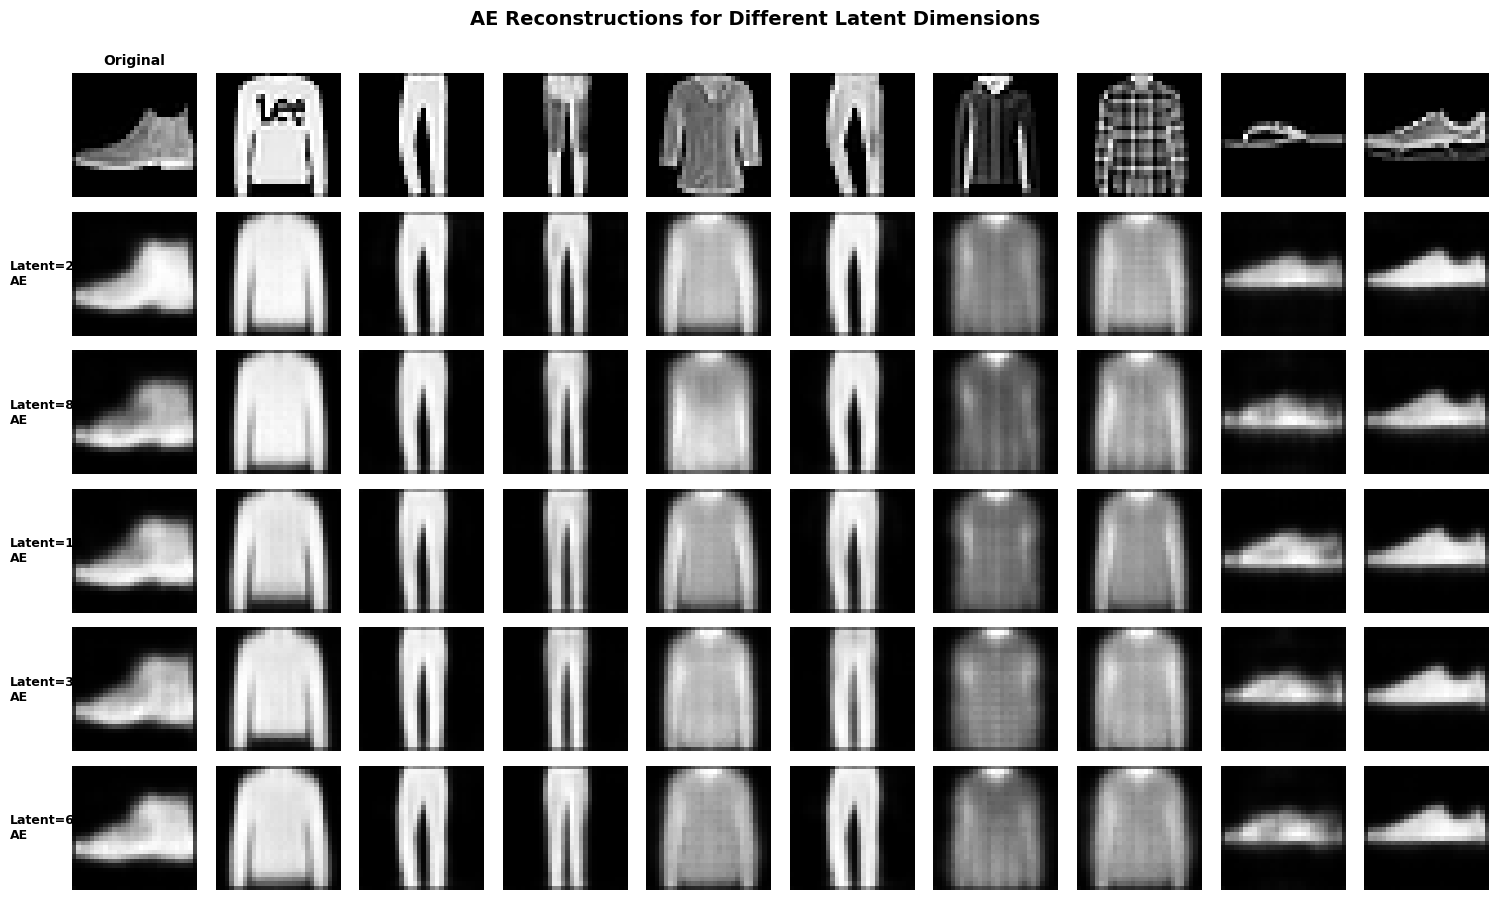

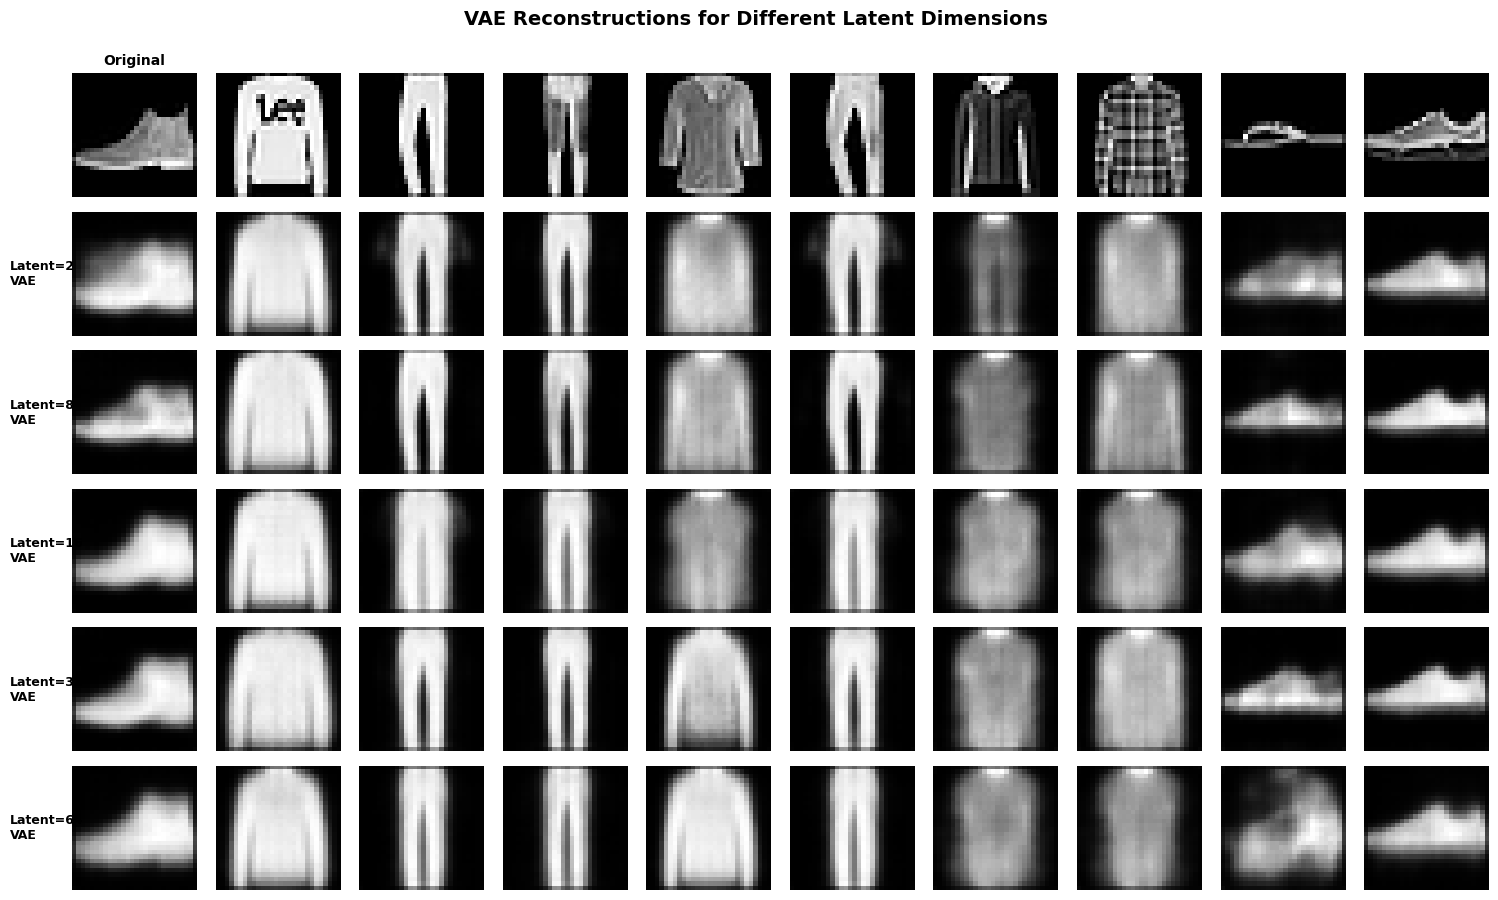

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstructions(ae_models, vae_models, test_loader, device, num_images=10):
    """Compare original images with AE and VAE reconstructions for different latent dimensions
        ae_models: Dictionary of trained AE models {latent_dim: model}
        vae_models: Dictionary of trained VAE models {latent_dim: model}
        test_loader: DataLoader for test data
        device: torch device
        num_images: Number of images to display  """
    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)

    latent_dims = sorted(ae_models.keys())

    # Create figure
    fig, axes = plt.subplots(len(latent_dims) + 1, num_images, figsize=(num_images * 1.5, (len(latent_dims) + 1) * 1.5))

    # Display original images in first row
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10, fontweight='bold')

    # Display reconstructions for each latent dimension
    row_idx = 1
    for latent_dim in latent_dims:
        # AE reconstructions
        ae_model = ae_models[latent_dim]
        ae_model.eval()
        with torch.no_grad():
            ae_recon, _ = ae_model(images)

        # VAE reconstructions
        vae_model = vae_models[latent_dim]
        vae_model.eval()
        with torch.no_grad():
            vae_recon, _, _ = vae_model(images)

        for i in range(num_images):
            # Create subplot with 2 rows (AE top, VAE bottom)
            if i == 0:
                axes[row_idx, i].text(-0.5, 0.5, f'Latent={latent_dim}\nAE',
                                      transform=axes[row_idx, i].transAxes,
                                      fontsize=9, fontweight='bold',
                                      verticalalignment='center',
                                      rotation=0)

            axes[row_idx, i].imshow(ae_recon[i].cpu().squeeze(), cmap='gray')
            axes[row_idx, i].axis('off')

        row_idx += 1

    plt.suptitle('AE Reconstructions for Different Latent Dimensions',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # Create second figure for VAE
    fig, axes = plt.subplots(len(latent_dims) + 1, num_images, figsize=(num_images * 1.5, (len(latent_dims) + 1) * 1.5))

    # Display original images in first row
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10, fontweight='bold')

    # Display VAE reconstructions
    row_idx = 1
    for latent_dim in latent_dims:
        vae_model = vae_models[latent_dim]
        vae_model.eval()
        with torch.no_grad():
            vae_recon, _, _ = vae_model(images)

        for i in range(num_images):
            if i == 0:
                axes[row_idx, i].text(-0.5, 0.5, f'Latent={latent_dim}\nVAE',
                                      transform=axes[row_idx, i].transAxes,
                                      fontsize=9, fontweight='bold',
                                      verticalalignment='center',
                                      rotation=0)

            axes[row_idx, i].imshow(vae_recon[i].cpu().squeeze(), cmap='gray')
            axes[row_idx, i].axis('off')

        row_idx += 1

    plt.suptitle('VAE Reconstructions for Different Latent Dimensions',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


# Usage
visualize_reconstructions(ae_models, vae_models, test_loader, device, num_images=10)

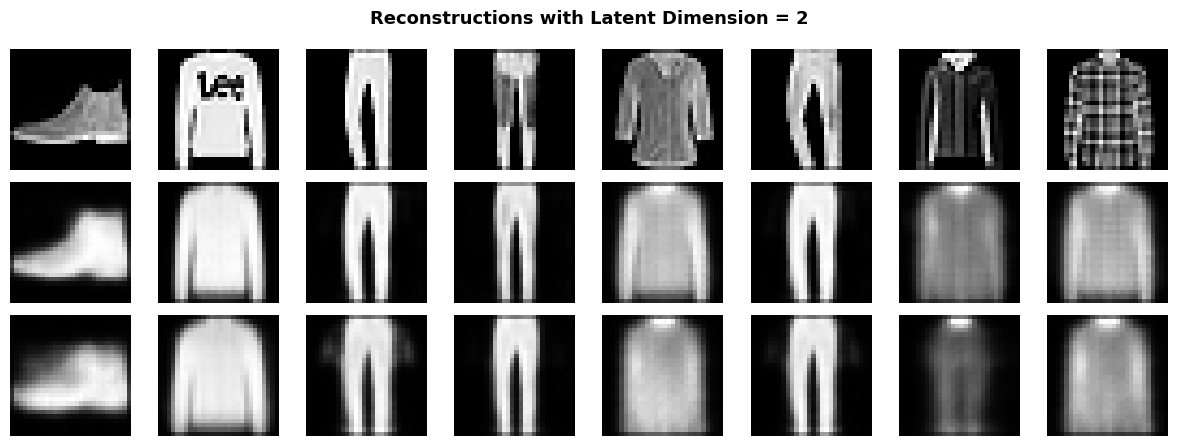

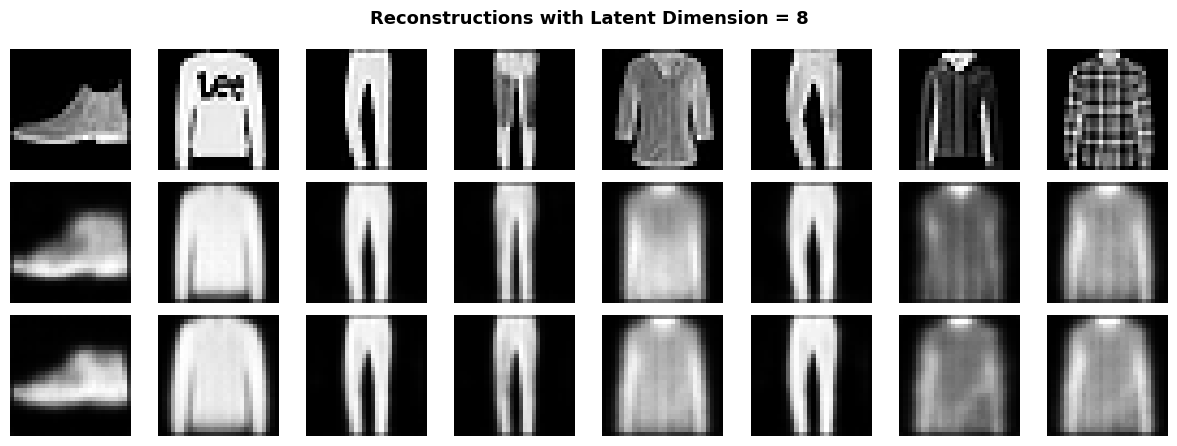

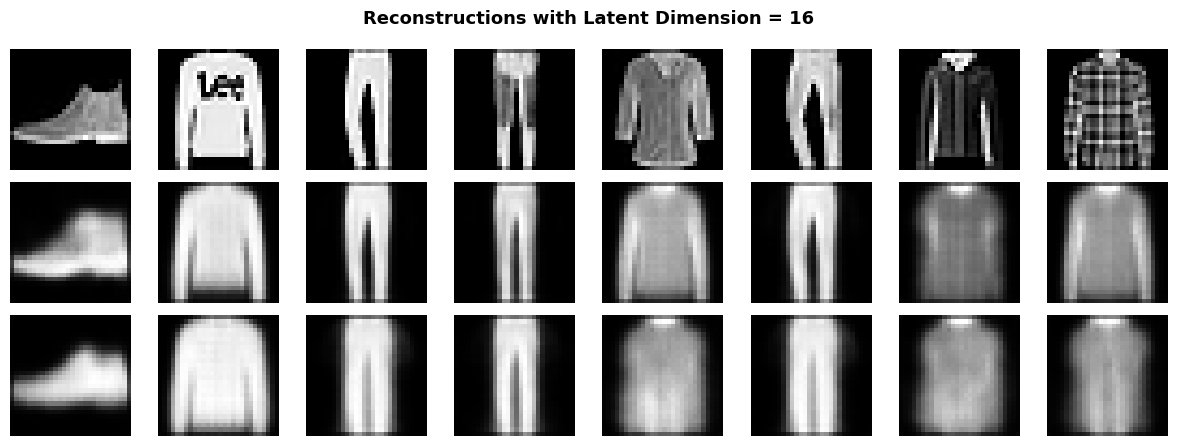

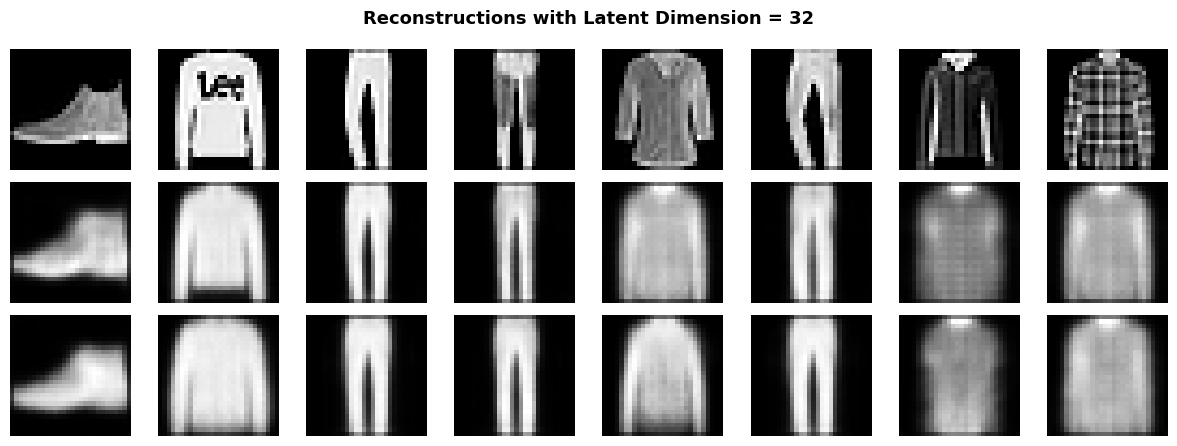

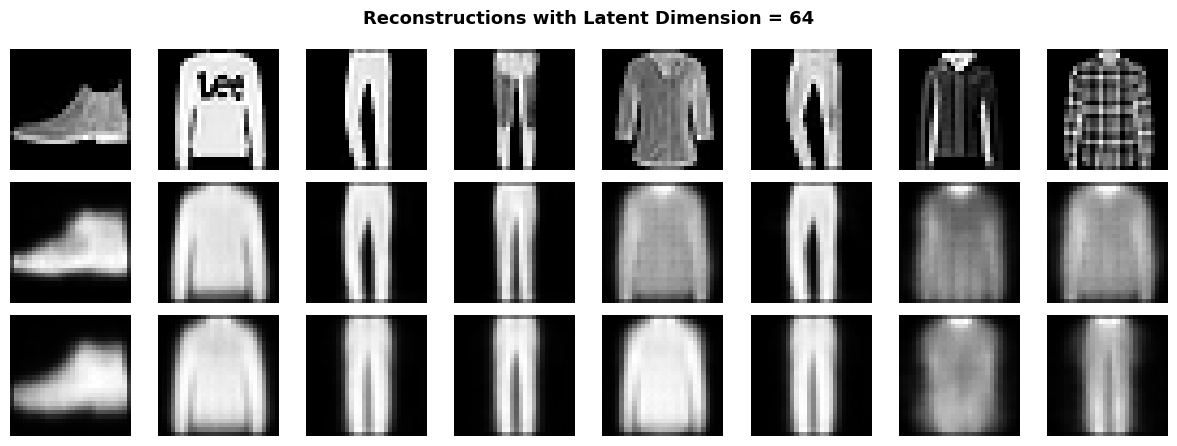

In [106]:
#Side-by-side comparison: Original | AE | VAE for each latent dimension
def compare_ae_vae_reconstructions(ae_models, vae_models, test_loader, device, num_images=8):
    # Get test images
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)

    latent_dims = sorted(ae_models.keys())

    for latent_dim in latent_dims:
        fig, axes = plt.subplots(3, num_images, figsize=(num_images * 1.5, 4.5))

        # Get reconstructions
        ae_model = ae_models[latent_dim]
        vae_model = vae_models[latent_dim]

        ae_model.eval()
        vae_model.eval()

        with torch.no_grad():
            ae_recon, _ = ae_model(images)
            vae_recon, _, _ = vae_model(images)

        # Plot
        for i in range(num_images):
            # Original
            axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=11, fontweight='bold')

            # AE Reconstruction
            axes[1, i].imshow(ae_recon[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('AE', fontsize=11, fontweight='bold')

            # VAE Reconstruction
            axes[2, i].imshow(vae_recon[i].cpu().squeeze(), cmap='gray')
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_ylabel('VAE', fontsize=11, fontweight='bold')

        plt.suptitle(f'Reconstructions with Latent Dimension = {latent_dim}',
                     fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()


# Usage
compare_ae_vae_reconstructions(ae_models, vae_models, test_loader, device, num_images=8)

### as we see AE reconstruction are more recogizble and sharper

In [108]:
def compute_reconstruction_metrics(ae_models, vae_models, test_loader, device):
    """
    Compute MSE and PSNR for different latent dimensions
    Returns:
        Dictionary with metrics for each latent dimension
    """
    latent_dims = sorted(ae_models.keys())

    metrics = {
        'latent_dims': latent_dims,
        'ae_mse': [],
        'vae_mse': [],
        'ae_psnr': [],
        'vae_psnr': []
    }

    for latent_dim in latent_dims:
        ae_model = ae_models[latent_dim]
        vae_model = vae_models[latent_dim]

        ae_model.eval()
        vae_model.eval()

        ae_total_mse = 0.0
        vae_total_mse = 0.0
        num_samples = 0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                batch_size = images.size(0)

                # AE reconstructions
                ae_recon, _ = ae_model(images)
                ae_mse = nn.functional.mse_loss(ae_recon, images, reduction='sum')
                ae_total_mse += ae_mse.item()

                # VAE reconstructions
                vae_recon, _, _ = vae_model(images)
                vae_mse = nn.functional.mse_loss(vae_recon, images, reduction='sum')
                vae_total_mse += vae_mse.item()

                num_samples += batch_size

        # Average MSE
        ae_avg_mse = ae_total_mse / num_samples
        vae_avg_mse = vae_total_mse / num_samples

        # PSNR (Peak Signal-to-Noise Ratio)
        # PSNR = 10 * log10(MAX^2 / MSE), MAX=1 for normalized images
        ae_psnr = 10 * np.log10(1.0 / ae_avg_mse) if ae_avg_mse > 0 else float('inf')
        vae_psnr = 10 * np.log10(1.0 / vae_avg_mse) if vae_avg_mse > 0 else float('inf')

        metrics['ae_mse'].append(ae_avg_mse)
        metrics['vae_mse'].append(vae_avg_mse)
        metrics['ae_psnr'].append(ae_psnr)
        metrics['vae_psnr'].append(vae_psnr)

        print(f"Latent Dim {latent_dim:3d} | AE MSE: {ae_avg_mse:.6f} | VAE MSE: {vae_avg_mse:.6f} | "
              f"AE PSNR: {ae_psnr:.2f} dB | VAE PSNR: {vae_psnr:.2f} dB")

    return metrics


# Compute metrics
metrics = compute_reconstruction_metrics(ae_models, vae_models, test_loader, device)

Latent Dim   2 | AE MSE: 22.877323 | VAE MSE: 27.581000 | AE PSNR: -13.59 dB | VAE PSNR: -14.41 dB
Latent Dim   8 | AE MSE: 23.396684 | VAE MSE: 26.457100 | AE PSNR: -13.69 dB | VAE PSNR: -14.23 dB
Latent Dim  16 | AE MSE: 22.842756 | VAE MSE: 31.639702 | AE PSNR: -13.59 dB | VAE PSNR: -15.00 dB
Latent Dim  32 | AE MSE: 23.108927 | VAE MSE: 27.662556 | AE PSNR: -13.64 dB | VAE PSNR: -14.42 dB
Latent Dim  64 | AE MSE: 23.152660 | VAE MSE: 32.982462 | AE PSNR: -13.65 dB | VAE PSNR: -15.18 dB


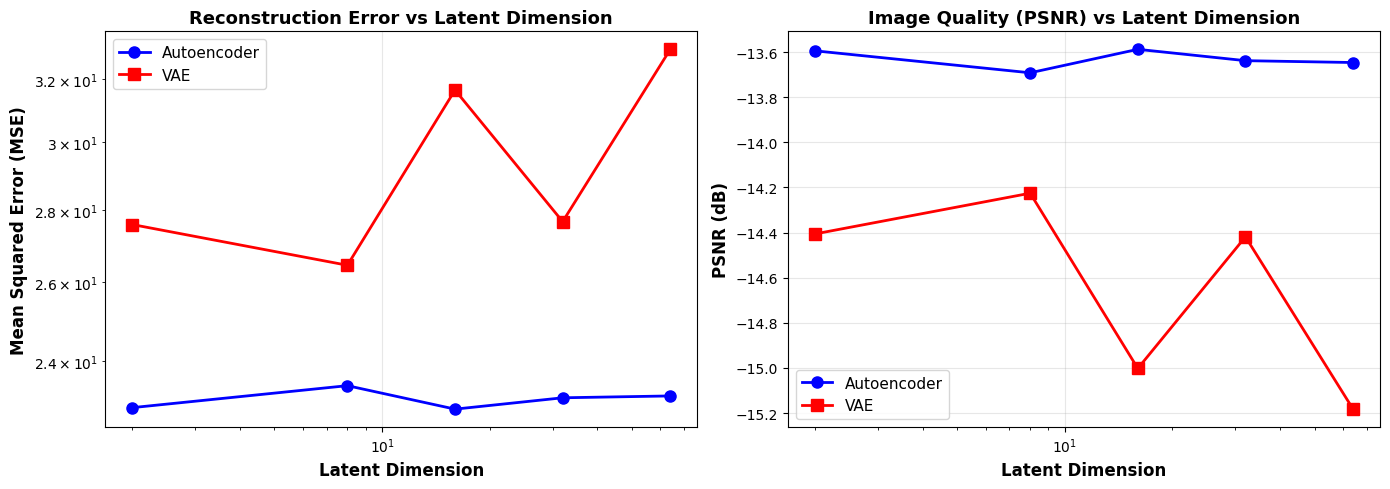

In [109]:
#Plot reconstruction metrics vs latent dimension size
def plot_reconstruction_performance(metrics):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    latent_dims = metrics['latent_dims']

    # Plot 1: MSE vs Latent Dimension
    axes[0].plot(latent_dims, metrics['ae_mse'], 'o-', linewidth=2, markersize=8,
                 label='Autoencoder', color='blue')
    axes[0].plot(latent_dims, metrics['vae_mse'], 's-', linewidth=2, markersize=8,
                 label='VAE', color='red')
    axes[0].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
    axes[0].set_title('Reconstruction Error vs Latent Dimension', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')

    # Plot 2: PSNR vs Latent Dimension (higher is better)
    axes[1].plot(latent_dims, metrics['ae_psnr'], 'o-', linewidth=2, markersize=8,
                 label='Autoencoder', color='blue')
    axes[1].plot(latent_dims, metrics['vae_psnr'], 's-', linewidth=2, markersize=8,
                 label='VAE', color='red')
    axes[1].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
    axes[1].set_title('Image Quality (PSNR) vs Latent Dimension', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')

    plt.tight_layout()
    plt.show()


# Plot the comparison
plot_reconstruction_performance(metrics)

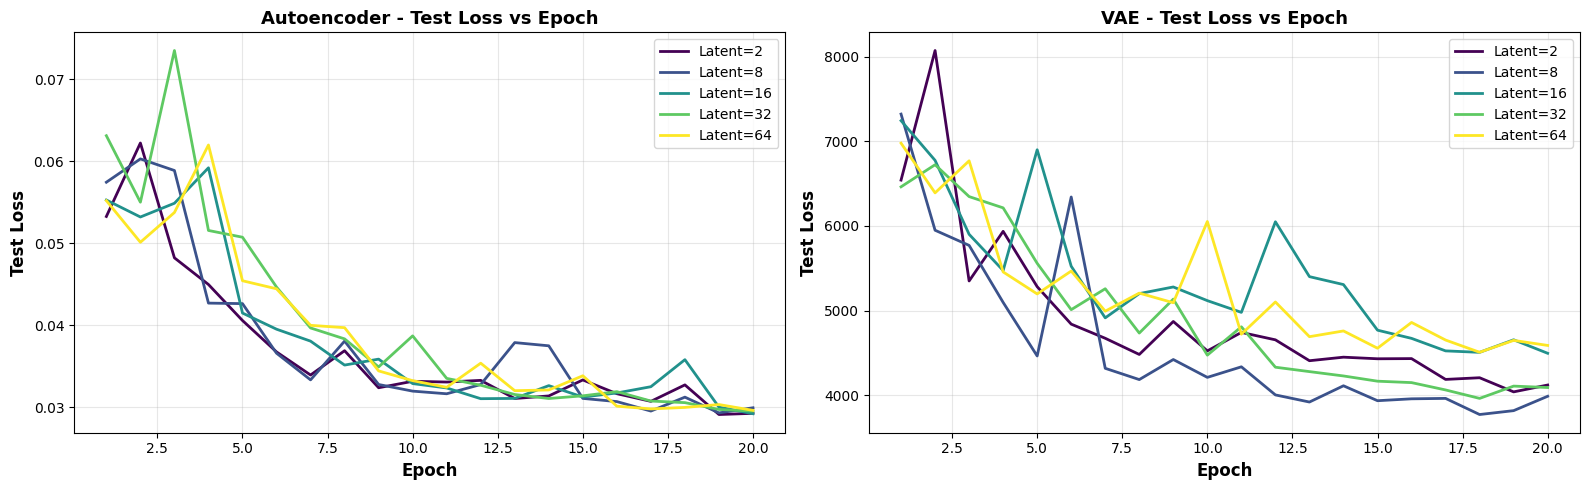

In [110]:
#Compare training curves for AE and VAE across different latent dimensions
def compare_training_curves(ae_histories, vae_histories):
    latent_dims = sorted(ae_histories.keys())

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    colors = plt.cm.viridis(np.linspace(0, 1, len(latent_dims)))

    # AE Training Curves
    for idx, latent_dim in enumerate(latent_dims):
        epochs_range = range(1, len(ae_histories[latent_dim]['train_loss']) + 1)
        axes[0].plot(epochs_range, ae_histories[latent_dim]['test_loss'],
                     '-', linewidth=2, color=colors[idx], label=f'Latent={latent_dim}')

    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Autoencoder - Test Loss vs Epoch', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # VAE Training Curves
    for idx, latent_dim in enumerate(latent_dims):
        epochs_range = range(1, len(vae_histories[latent_dim]['train_loss']) + 1)
        axes[1].plot(epochs_range, vae_histories[latent_dim]['test_loss'],
                     '-', linewidth=2, color=colors[idx], label=f'Latent={latent_dim}')

    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
    axes[1].set_title('VAE - Test Loss vs Epoch', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot training curves
compare_training_curves(ae_histories, vae_histories)

# **Discussions**
1-AEs generally compress better than VAEs at small latent size, Because:

-AE acheives higher PSNR,lower error and sharper reconstruction

-visual evidence (AE more recognizable)

-AE they only optimize reconstruction error while VAE optimize 2 term objective (recons+KL divergence)



---



2-VAE reconstructions are blurrier because:

-stochastic sampling and KL regularization encourage averaging and smooth latent representations

-VAEs encode each image as a distribtion and add noise during reconstruction,because of this noise , VAE learns to average possible outputs and this averaging removes fine details=>blur


# **Task 2:Latent Space Clustering+Classification**

#### **1) & 2) included in 3)**
# **3)Extract latent vectors**

In [10]:
#load ae and vae models
import torch
import os

# Initialize dictionaries
ae_models = {}
vae_models = {}

latent_dims = [2, 8, 16, 32, 64]
drive_dir = "/content/drive/MyDrive/Computer Vision/assignment1/models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load all saved models
for latent_dim in latent_dims:
    print(f"\nLoading models for latent_dim = {latent_dim}...")

    # Load AE
    ae_path = os.path.join(drive_dir, f"conv_ae_latent{latent_dim}.pth")
    if os.path.exists(ae_path):
        checkpoint = torch.load(ae_path, map_location=device)
        ae_model = ConvAutoEncoder(latent_dim=latent_dim).to(device)
        ae_model.load_state_dict(checkpoint['model_state_dict'])
        ae_model.eval()
        ae_models[latent_dim] = ae_model
        print(f"  AE loaded from {ae_path}")
    else:
        print(f"  AE not found: {ae_path}")

    # Load VAE
    vae_path = os.path.join(drive_dir, f"conv_vae_latent{latent_dim}.pth")
    if os.path.exists(vae_path):
        checkpoint = torch.load(vae_path, map_location=device)
        vae_model = ConvVAE(latent_dim=latent_dim).to(device)
        vae_model.load_state_dict(checkpoint['model_state_dict'])
        vae_model.eval()
        vae_models[latent_dim] = vae_model
        print(f"   VAE loaded from {vae_path}")
    else:
        print(f"   VAE not found: {vae_path}")

print(f"\n Loaded {len(ae_models)} AE models: {list(ae_models.keys())}")
print(f" Loaded {len(vae_models)} VAE models: {list(vae_models.keys())}")


Loading models for latent_dim = 2...
  AE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent2.pth
   VAE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent2.pth

Loading models for latent_dim = 8...
  AE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent8.pth
   VAE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent8.pth

Loading models for latent_dim = 16...
  AE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent16.pth
   VAE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent16.pth

Loading models for latent_dim = 32...
  AE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_ae_latent32.pth
   VAE loaded from /content/drive/MyDrive/Computer Vision/assignment1/models/conv_vae_latent32.pth

Loading models for latent_dim = 64...
  AE loaded from /content/drive

In [11]:
import numpy as np

#Extract latent representations from AE and VAE
def extract_latent_representations(model, data_loader, device, model_type='ae', num_samples=2000):
    """
        params:
        model: Trained AE or VAE model
        data_loader: DataLoader for the dataset
        model_type: 'ae' or 'vae'
        num_samples: Number of samples to extract (None for all)

        Returns:
        latent_vectors: numpy array of shape (num_samples, latent_dim)
        labels: numpy array of shape (num_samples,)
        images: numpy array of original images
    """
    model.eval()

    latent_vectors = []
    labels_list = []
    images_list = []

    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            if num_samples is not None and total_samples >= num_samples:
                break

            images = images.to(device)
            batch_size = images.size(0)

            # Encode
            if model_type == 'ae':
                latent = model.encode(images)  # AE: direct latent vector
            elif model_type == 'vae':
                mu, logvar = model.encode(images)  # VAE: use mu as representation
                latent = mu
            else:
                raise ValueError("model_type must be 'ae' or 'vae'")

            # Collect samples
            samples_to_take = min(batch_size, num_samples - total_samples) if num_samples else batch_size

            latent_vectors.append(latent[:samples_to_take].cpu().numpy())
            labels_list.append(labels[:samples_to_take].numpy())
            images_list.append(images[:samples_to_take].cpu().numpy())

            total_samples += samples_to_take

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    images_array = np.concatenate(images_list, axis=0)

    print(f"  Extracted {latent_vectors.shape[0]} latent vectors")
    print(f"  Latent dimension: {latent_vectors.shape[1]}")
    print(f"  Labels shape: {labels_array.shape}")

    return latent_vectors, labels_array, images_array


# Example usage: Extract latent representations for latent_dim=32
latent_dim = 32  # Choose your dimension

print("Extracting AE latent representations...")
ae_latent, ae_labels, ae_images = extract_latent_representations(
    ae_models[latent_dim], test_loader, device, model_type='ae', num_samples=2000
)

print("\nExtracting VAE latent representations...")
vae_latent, vae_labels, vae_images = extract_latent_representations(
    vae_models[latent_dim], test_loader, device, model_type='vae', num_samples=2000
)

Extracting AE latent representations...
  Extracted 2000 latent vectors
  Latent dimension: 32
  Labels shape: (2000,)

Extracting VAE latent representations...
  Extracted 2000 latent vectors
  Latent dimension: 32
  Labels shape: (2000,)


# **Plot 1: Visualization of the latent space**

LATENT SPACE VISUALIZATION

Visualizing latent spaces using TSNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


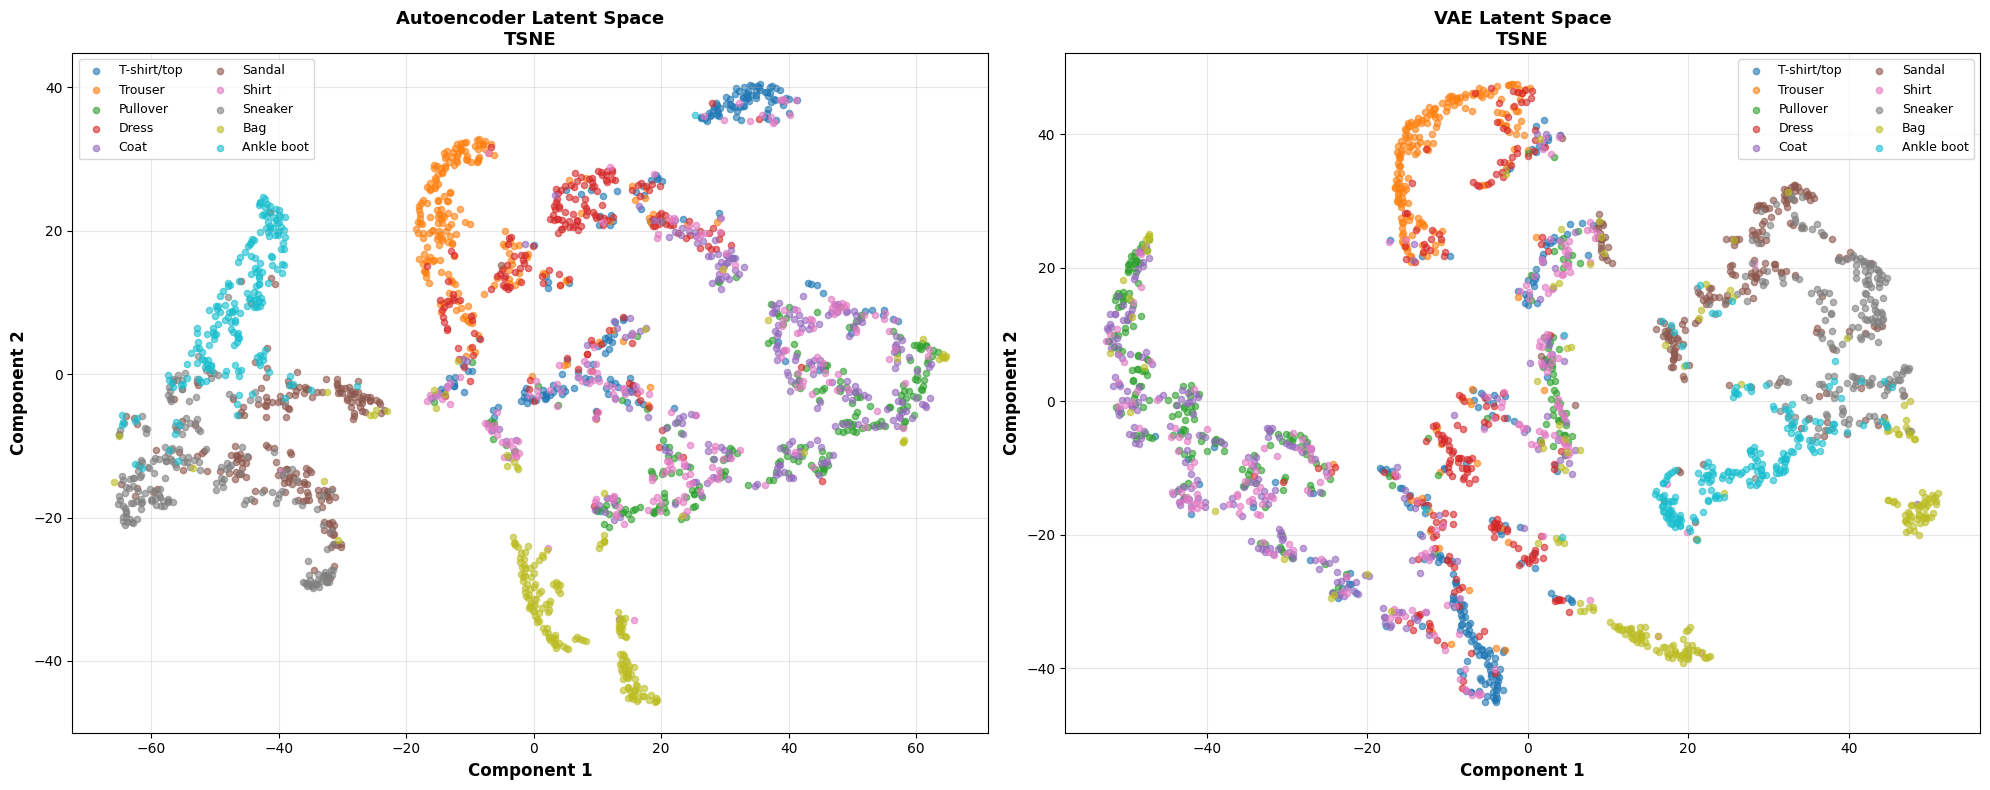


Visualizing latent spaces using PCA...


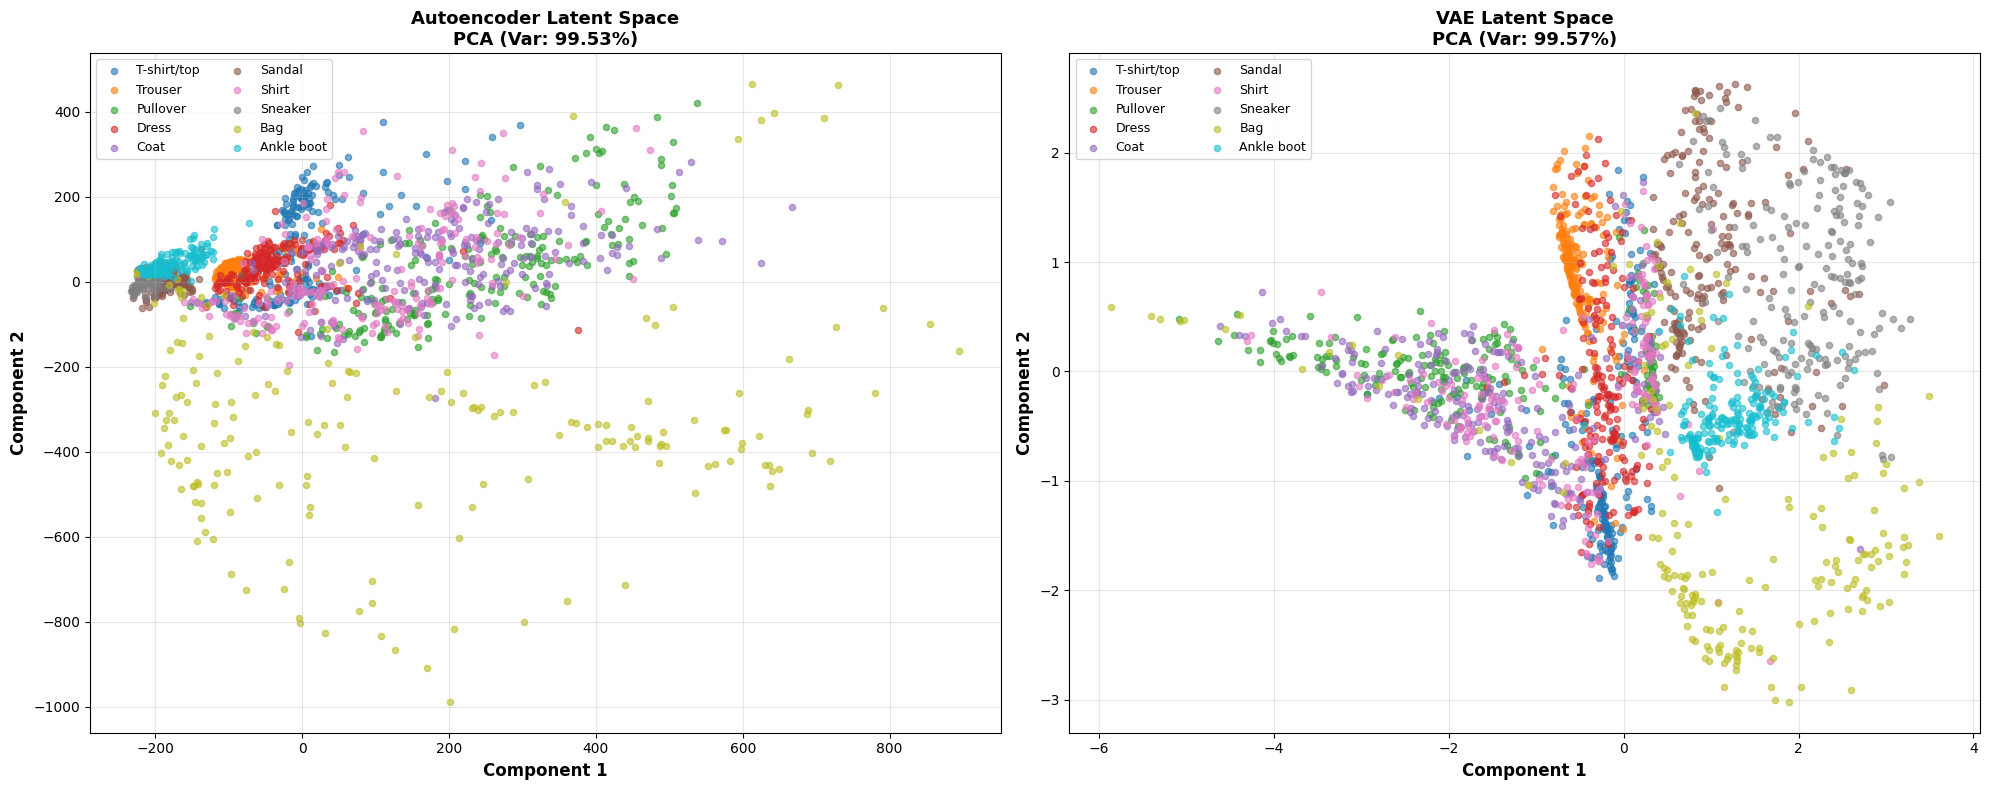

In [12]:
# Visualize high-dimensional latent space in 2D using PCA or t-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space_2d(latent_vectors, labels, method='tsne', title='Latent Space Visualization'):
    """
        latent_vectors: numpy array of shape (n_samples, latent_dim)
        labels: numpy array of shape (n_samples,)
        method: 'pca' or 'tsne'
        title: Plot title
    """
    print(f"Reducing dimensionality using {method.upper()}...")

    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        latent_2d = reducer.fit_transform(latent_vectors)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'PCA (Explained Variance: {explained_var[0]:.2%} + {explained_var[1]:.2%} = {sum(explained_var):.2%})'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        latent_2d = reducer.fit_transform(latent_vectors)
        subtitle = 't-SNE (perplexity=30)'
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    # Fashion-MNIST class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Create plot
    plt.figure(figsize=(12, 10))

    # Plot each class with different color
    scatter_plots = []
    for i in range(10):
        mask = labels == i
        scatter = plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                             label=class_names[i], alpha=0.6, s=20)
        scatter_plots.append(scatter)

    plt.xlabel('Component 1', fontsize=12, fontweight='bold')
    plt.ylabel('Component 2', fontsize=12, fontweight='bold')
    plt.title(f'{title}\n{subtitle}', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=10, ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return latent_2d


#Side-by-side comparison of AE and VAE latent spaces
def compare_ae_vae_latent_spaces(ae_latent, vae_latent, labels, method='tsne'):
    print(f"\nVisualizing latent spaces using {method.upper()}...")

    if method == 'pca':
        ae_reducer = PCA(n_components=2, random_state=42)
        vae_reducer = PCA(n_components=2, random_state=42)
        ae_2d = ae_reducer.fit_transform(ae_latent)
        vae_2d = vae_reducer.fit_transform(vae_latent)
        ae_var = sum(ae_reducer.explained_variance_ratio_)
        vae_var = sum(vae_reducer.explained_variance_ratio_)
    else:
        ae_reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        vae_reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        ae_2d = ae_reducer.fit_transform(ae_latent)
        vae_2d = vae_reducer.fit_transform(vae_latent)

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # AE latent space
    for i in range(10):
        mask = labels == i
        axes[0].scatter(ae_2d[mask, 0], ae_2d[mask, 1],
                       label=class_names[i], alpha=0.6, s=20)

    axes[0].set_xlabel('Component 1', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Component 2', fontsize=12, fontweight='bold')
    title_ae = f'Autoencoder Latent Space\n{method.upper()}'
    if method == 'pca':
        title_ae += f' (Var: {ae_var:.2%})'
    axes[0].set_title(title_ae, fontsize=13, fontweight='bold')
    axes[0].legend(loc='best', fontsize=9, ncol=2)
    axes[0].grid(True, alpha=0.3)

    # VAE latent space
    for i in range(10):
        mask = labels == i
        axes[1].scatter(vae_2d[mask, 0], vae_2d[mask, 1],
                       label=class_names[i], alpha=0.6, s=20)

    axes[1].set_xlabel('Component 1', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Component 2', fontsize=12, fontweight='bold')
    title_vae = f'VAE Latent Space\n{method.upper()}'
    if method == 'pca':
        title_vae += f' (Var: {vae_var:.2%})'
    axes[1].set_title(title_vae, fontsize=13, fontweight='bold')
    axes[1].legend(loc='best', fontsize=9, ncol=2)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return ae_2d, vae_2d


# Visualize using both PCA and t-SNE
print("LATENT SPACE VISUALIZATION")

# Compare using t-SNE
ae_2d_tsne, vae_2d_tsne = compare_ae_vae_latent_spaces(ae_latent, vae_latent, ae_labels, method='tsne')

# Compare using PCA
ae_2d_pca, vae_2d_pca = compare_ae_vae_latent_spaces(ae_latent, vae_latent, ae_labels, method='pca')

# **4)Unsupervised Clustering in the latent space**


[AE] Clustering Results:

Performing K-means clustering (k=10)...
  Adjusted Rand Index (ARI): 0.2869
  Normalized Mutual Info (NMI): 0.4736
  Silhouette Score: 0.4713

[VAE] Clustering Results:

Performing K-means clustering (k=10)...
  Adjusted Rand Index (ARI): 0.2889
  Normalized Mutual Info (NMI): 0.4581
  Silhouette Score: 0.4440


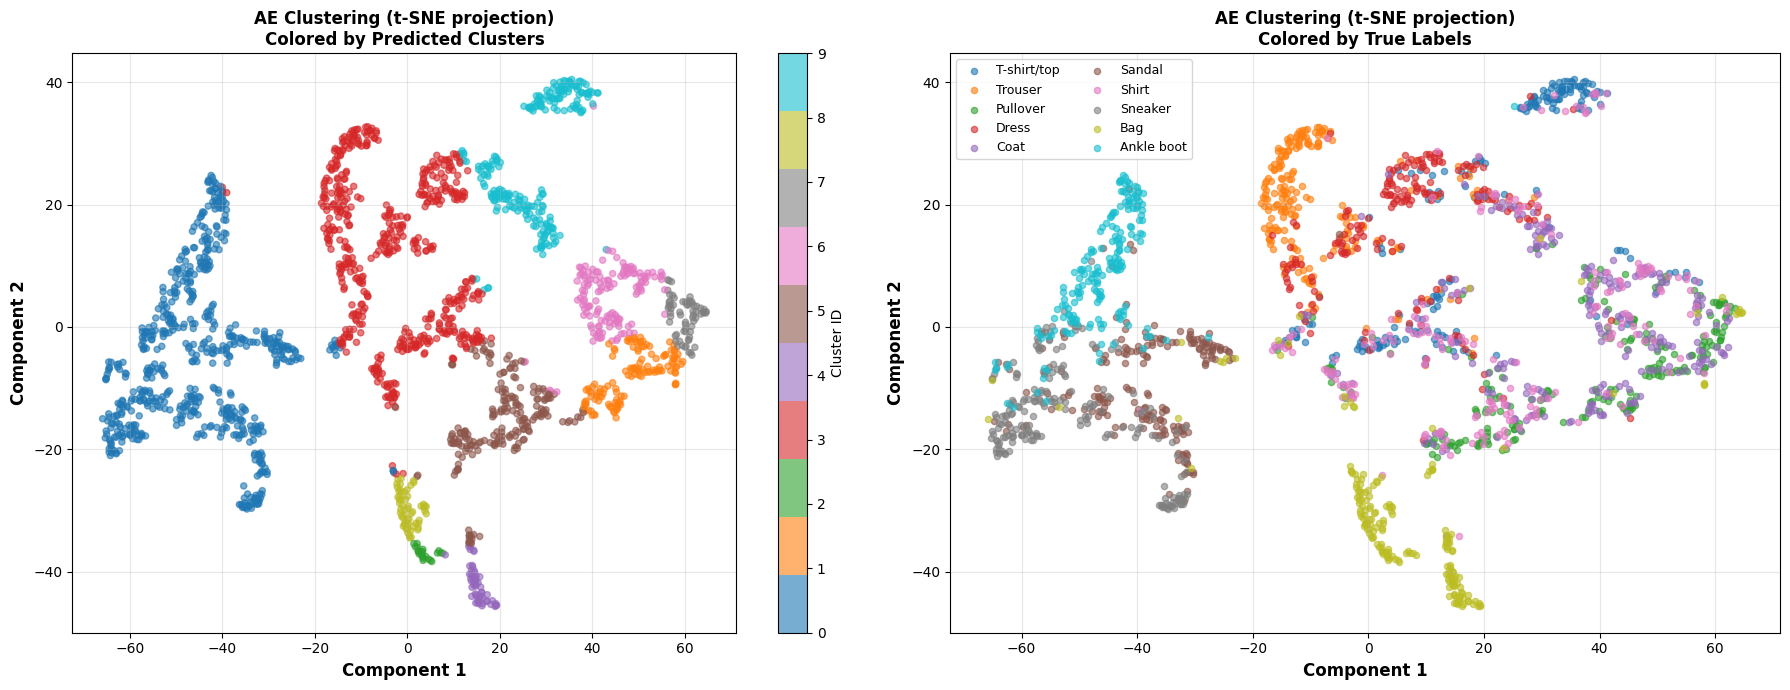

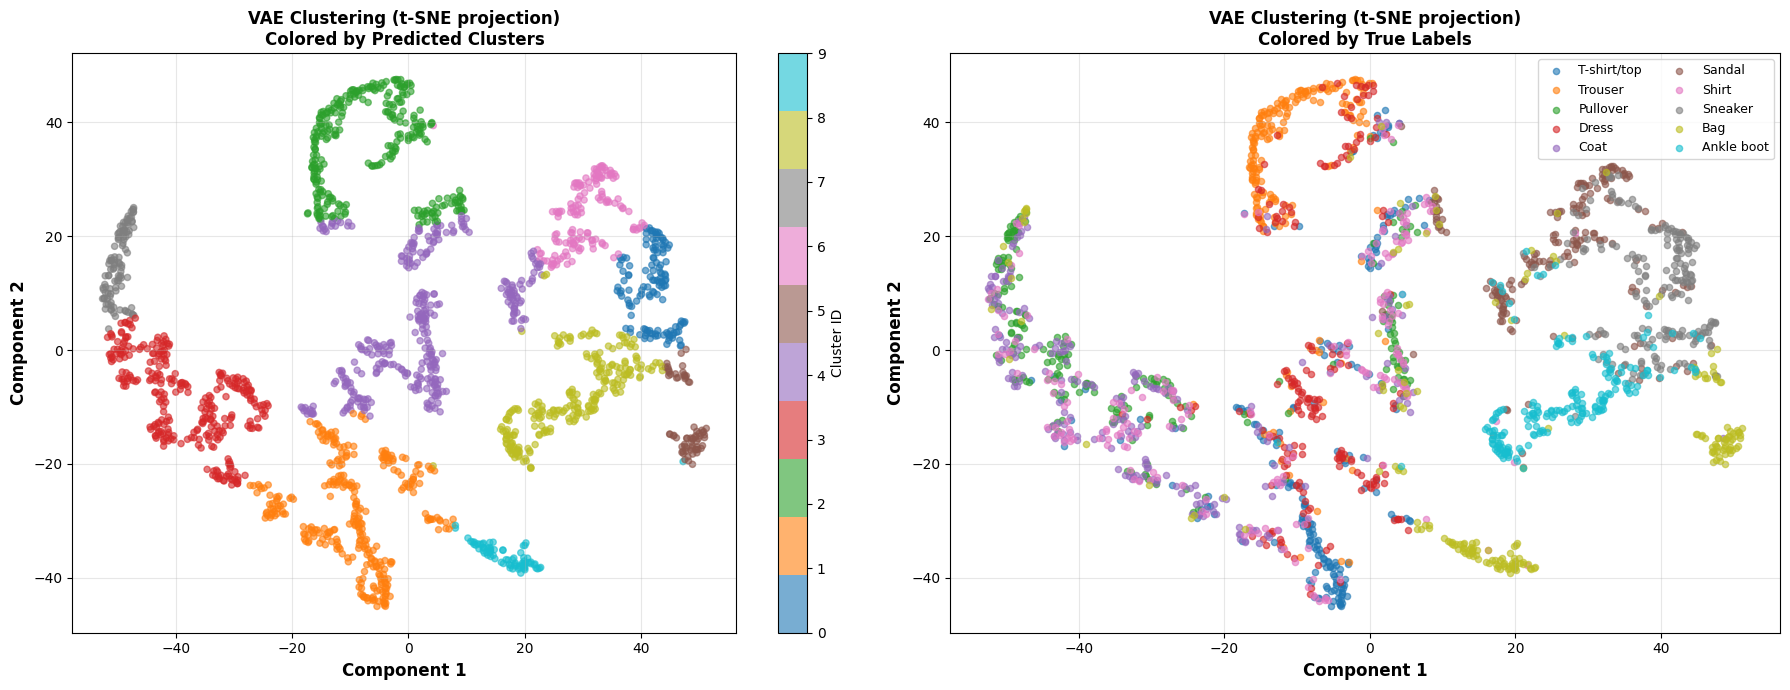

In [13]:
#Perform K-means clustering on latent space
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

def perform_clustering(latent_vectors, true_labels, n_clusters=10):
    """
    true_labels: numpy array of ground truth labels
    Returns:
    clustering results and metrics
    """
    print(f"\nPerforming K-means clustering (k={n_clusters})...")

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    # Compute clustering metrics
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    silhouette = silhouette_score(latent_vectors, cluster_labels)

    print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
    print(f"  Silhouette Score: {silhouette:.4f}")

    return {
        'cluster_labels': cluster_labels,
        'ari': ari,
        'nmi': nmi,
        'silhouette': silhouette
    }

#Visualize clustering results on 2D latent space
def visualize_clusters(latent_2d, cluster_labels, true_labels, title='Clustering Results'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot 1: Colored by predicted clusters
    scatter1 = axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1],
                               c=cluster_labels, cmap='tab10', alpha=0.6, s=20)
    axes[0].set_xlabel('Component 1', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Component 2', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{title}\nColored by Predicted Clusters', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

    # Plot 2: Colored by true labels
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    for i in range(10):
        mask = true_labels == i
        axes[1].scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                       label=class_names[i], alpha=0.6, s=20)

    axes[1].set_xlabel('Component 1', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Component 2', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{title}\nColored by True Labels', fontsize=12, fontweight='bold')
    axes[1].legend(loc='best', fontsize=9, ncol=2)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Perform clustering
print("\n[AE] Clustering Results:")
ae_clustering = perform_clustering(ae_latent, ae_labels, n_clusters=10)

print("\n[VAE] Clustering Results:")
vae_clustering = perform_clustering(vae_latent, vae_labels, n_clusters=10)

# Visualize clustering results
visualize_clusters(ae_2d_tsne, ae_clustering['cluster_labels'], ae_labels,
                   title='AE Clustering (t-SNE projection)')
visualize_clusters(vae_2d_tsne, vae_clustering['cluster_labels'], vae_labels,
                   title='VAE Clustering (t-SNE projection)')

# **5)Train multiple classifiers using latent vectors**

In [14]:
#Train multiple classifiers on latent representations
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

def train_classifiers(latent_train, labels_train, latent_test, labels_test):
   #returns Dictionary of trained classifiers and their accuracies
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM (Linear)': SVC(kernel='linear', random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'k-NN (k=10)': KNeighborsClassifier(n_neighbors=10)
    }

    results = {}

    print("\nTraining classifiers on latent space...")
    for name, clf in classifiers.items():
        print(f"\n[{name}]")

        # Train
        clf.fit(latent_train, labels_train)

        # Predict
        train_pred = clf.predict(latent_train)
        test_pred = clf.predict(latent_test)

        # Evaluate
        train_acc = accuracy_score(labels_train, train_pred)
        test_acc = accuracy_score(labels_test, test_pred)

        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")

        results[name] = {
            'classifier': clf,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'predictions': test_pred
        }

    return results


# Split data into train/test for classification
# Note: We already have test_loader, but let's create a proper train/test split
# from our extracted latent vectors

# For this example, let's extract more samples and split them
def extract_latent_for_classification(model, train_loader, test_loader, device,model_type='ae', train_samples=5000, test_samples=1000):
    print(f"\nExtracting latent vectors for classification...")

    # Extract from training set
    train_latent, train_labels, _ = extract_latent_representations(
        model, train_loader, device, model_type, num_samples=train_samples
    )

    # Extract from test set
    test_latent, test_labels, _ = extract_latent_representations(
        model, test_loader, device, model_type, num_samples=test_samples
    )

    return train_latent, train_labels, test_latent, test_labels


# Extract latent vectors for classification (using latent_dim=32 as example)
latent_dim = 32

print(f"CLASSIFICATION TASK (Latent Dim = {latent_dim})")

# AE
print("\n[Autoencoder]")
ae_train_latent, ae_train_labels, ae_test_latent, ae_test_labels = extract_latent_for_classification(
    ae_models[latent_dim], train_loader, test_loader, device,
    model_type='ae', train_samples=5000, test_samples=2000
)

ae_classifier_results = train_classifiers(ae_train_latent, ae_train_labels,
                                          ae_test_latent, ae_test_labels)

# VAE
print("\n" + "=" * 70)
print("[VAE]")
vae_train_latent, vae_train_labels, vae_test_latent, vae_test_labels = extract_latent_for_classification(
    vae_models[latent_dim], train_loader, test_loader, device,
    model_type='vae', train_samples=5000, test_samples=2000
)

vae_classifier_results = train_classifiers(vae_train_latent, vae_train_labels,
                                           vae_test_latent, vae_test_labels)

CLASSIFICATION TASK (Latent Dim = 32)

[Autoencoder]

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 32
  Labels shape: (5000,)
  Extracted 2000 latent vectors
  Latent dimension: 32
  Labels shape: (2000,)

Training classifiers on latent space...

[Logistic Regression]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.6838
  Test Accuracy:  0.6700

[SVM (Linear)]
  Train Accuracy: 0.7278
  Test Accuracy:  0.7100

[SVM (RBF)]
  Train Accuracy: 0.6610
  Test Accuracy:  0.6440

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6415

[k-NN (k=5)]
  Train Accuracy: 0.7486
  Test Accuracy:  0.6460

[k-NN (k=10)]
  Train Accuracy: 0.7202
  Test Accuracy:  0.6600

[VAE]

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 32
  Labels shape: (5000,)
  Extracted 2000 latent vectors
  Latent dimension: 32
  Labels shape: (2000,)

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.5934
  Test Accuracy:  0.5745

[SVM (Linear)]
  Train Accuracy: 0.6142
  Test Accuracy:  0.6050

[SVM (RBF)]
  Train Accuracy: 0.6270
  Test Accuracy:  0.6195

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6705

[k-NN (k=5)]
  Train Accuracy: 0.7114
  Test Accuracy:  0.6060

[k-NN (k=10)]
  Train Accuracy: 0.68

# **6)Evaluation part (performance,confusion matrix)**

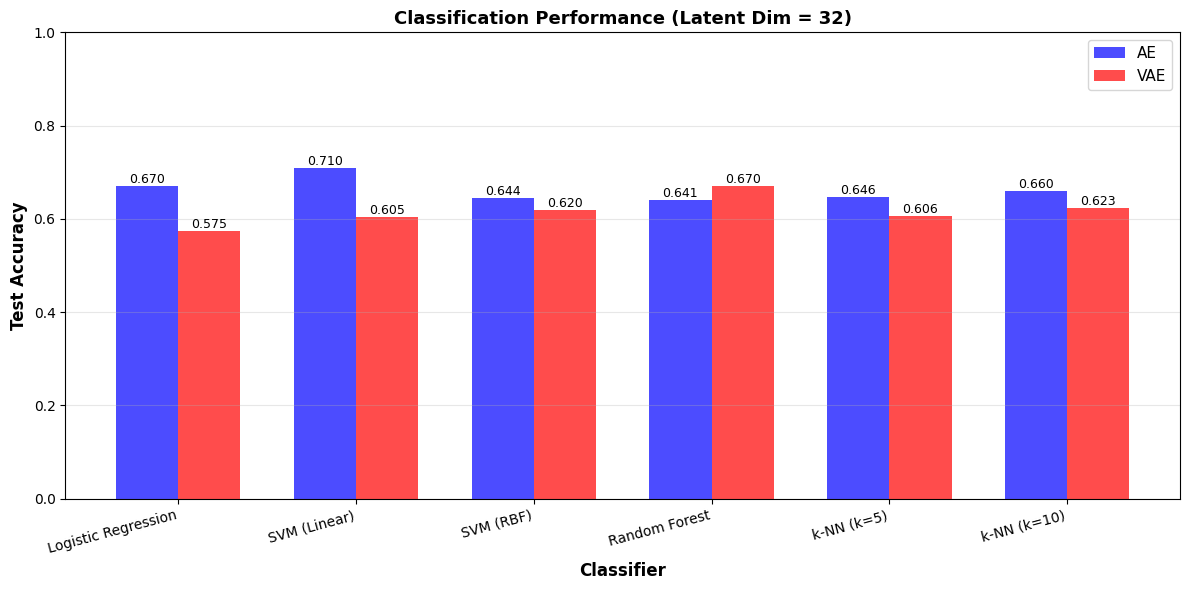

CLASSIFICATION ACCURACY SUMMARY
Classifier                AE Accuracy     VAE Accuracy    Winner    
Logistic Regression       0.6700          0.5745          AE        
SVM (Linear)              0.7100          0.6050          AE        
SVM (RBF)                 0.6440          0.6195          AE        
Random Forest             0.6415          0.6705          VAE       
k-NN (k=5)                0.6460          0.6060          AE        
k-NN (k=10)               0.6600          0.6230          AE        


In [15]:
#Compare AE vs VAE classification performance
def compare_classifier_performance(ae_results, vae_results, title='Classification Performance Comparison'):
    classifier_names = list(ae_results.keys())
    ae_accuracies = [ae_results[name]['test_accuracy'] for name in classifier_names]
    vae_accuracies = [vae_results[name]['test_accuracy'] for name in classifier_names]

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(classifier_names))
    width = 0.35

    bars1 = ax.bar(x - width/2, ae_accuracies, width, label='AE', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, vae_accuracies, width, label='VAE', color='red', alpha=0.7)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Classifier', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classifier_names, rotation=15, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Print summary
    print("CLASSIFICATION ACCURACY SUMMARY")
    print(f"{'Classifier':<25} {'AE Accuracy':<15} {'VAE Accuracy':<15} {'Winner':<10}")

    for name in classifier_names:
        ae_acc = ae_results[name]['test_accuracy']
        vae_acc = vae_results[name]['test_accuracy']
        winner = 'AE' if ae_acc > vae_acc else 'VAE' if vae_acc > ae_acc else 'Tie'
        print(f"{name:<25} {ae_acc:<15.4f} {vae_acc:<15.4f} {winner:<10}")

# Compare results
compare_classifier_performance(ae_classifier_results, vae_classifier_results,
                               title=f'Classification Performance (Latent Dim = {latent_dim})')

EVALUATING CLASSIFICATION ACROSS LATENT DIMENSIONS
Evaluating Latent Dimension = 2

[AE] Extracting latent vectors...

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 2
  Labels shape: (5000,)
  Extracted 2000 latent vectors
  Latent dimension: 2
  Labels shape: (2000,)

[VAE] Extracting latent vectors...

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 2
  Labels shape: (5000,)
  Extracted 2000 latent vectors
  Latent dimension: 2
  Labels shape: (2000,)

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.4916
  Test Accuracy:  0.4950

[SVM (Linear)]
  Train Accuracy: 0.6046
  Test Accuracy:  0.5815

[SVM (RBF)]
  Train Accuracy: 0.6966
  Test Accuracy:  0.6800

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6310

[k-NN (k=5)]
  Train Accuracy: 0.7640
  Test Accuracy:  0.6505

[k-NN (k=10)]
  Train Accuracy: 0.7338
  Test Accuracy:  0.66

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.6666
  Test Accuracy:  0.6550

[SVM (Linear)]
  Train Accuracy: 0.7084
  Test Accuracy:  0.6955

[SVM (RBF)]
  Train Accuracy: 0.6800
  Test Accuracy:  0.6570

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6490

[k-NN (k=5)]
  Train Accuracy: 0.7560
  Test Accuracy:  0.6525

[k-NN (k=10)]
  Train Accuracy: 0.7316
  Test Accuracy:  0.6680

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.6190
  Test Accuracy:  0.6040

[SVM (Linear)]
  Train Accuracy: 0.6488
  Test Accuracy:  0.6320

[SVM (RBF)]
  Train Accuracy: 0.6930
  Test Accuracy:  0.6870

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6965

[k-NN (k=5)]
  Train Accuracy: 0.7626
  Test Accuracy:  0.6560

[k-NN (k=10)]
  Train Accuracy: 0.7412
  Test Accuracy:  0.6755
Evaluating Latent Dimension = 16

[AE] Extracting latent vectors...

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 16
  Labels shape

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.6578
  Test Accuracy:  0.6565

[SVM (Linear)]
  Train Accuracy: 0.7254
  Test Accuracy:  0.7130

[SVM (RBF)]
  Train Accuracy: 0.6526
  Test Accuracy:  0.6375

[Random Forest]
  Train Accuracy: 0.9998
  Test Accuracy:  0.6690

[k-NN (k=5)]
  Train Accuracy: 0.7604
  Test Accuracy:  0.6650

[k-NN (k=10)]
  Train Accuracy: 0.7336
  Test Accuracy:  0.6710

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.5604
  Test Accuracy:  0.5525

[SVM (Linear)]
  Train Accuracy: 0.5664
  Test Accuracy:  0.5595

[SVM (RBF)]
  Train Accuracy: 0.5792
  Test Accuracy:  0.5775

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6440

[k-NN (k=5)]
  Train Accuracy: 0.7166
  Test Accuracy:  0.6145

[k-NN (k=10)]
  Train Accuracy: 0.6732
  Test Accuracy:  0.6080
Evaluating Latent Dimension = 32

[AE] Extracting latent vectors...

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 32
  Labels shape

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.6748
  Test Accuracy:  0.6660

[SVM (Linear)]
  Train Accuracy: 0.7222
  Test Accuracy:  0.7060

[SVM (RBF)]
  Train Accuracy: 0.6488
  Test Accuracy:  0.6435

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6285

[k-NN (k=5)]
  Train Accuracy: 0.7478
  Test Accuracy:  0.6365

[k-NN (k=10)]
  Train Accuracy: 0.7186
  Test Accuracy:  0.6480

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.5976
  Test Accuracy:  0.5745

[SVM (Linear)]
  Train Accuracy: 0.6200
  Test Accuracy:  0.6130

[SVM (RBF)]
  Train Accuracy: 0.6368
  Test Accuracy:  0.6160

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6790

[k-NN (k=5)]
  Train Accuracy: 0.7142
  Test Accuracy:  0.6060

[k-NN (k=10)]
  Train Accuracy: 0.6872
  Test Accuracy:  0.6235
Evaluating Latent Dimension = 64

[AE] Extracting latent vectors...

Extracting latent vectors for classification...
  Extracted 5000 latent vectors
  Latent dimension: 64
  Labels shape

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.6364
  Test Accuracy:  0.6100

[SVM (Linear)]
  Train Accuracy: 0.7446
  Test Accuracy:  0.7335

[SVM (RBF)]
  Train Accuracy: 0.6790
  Test Accuracy:  0.6750

[Random Forest]
  Train Accuracy: 0.9998
  Test Accuracy:  0.6460

[k-NN (k=5)]
  Train Accuracy: 0.7526
  Test Accuracy:  0.6475

[k-NN (k=10)]
  Train Accuracy: 0.7282
  Test Accuracy:  0.6615

Training classifiers on latent space...

[Logistic Regression]
  Train Accuracy: 0.5916
  Test Accuracy:  0.5875

[SVM (Linear)]
  Train Accuracy: 0.5792
  Test Accuracy:  0.5695

[SVM (RBF)]
  Train Accuracy: 0.5832
  Test Accuracy:  0.5750

[Random Forest]
  Train Accuracy: 1.0000
  Test Accuracy:  0.6705

[k-NN (k=5)]
  Train Accuracy: 0.7194
  Test Accuracy:  0.6010

[k-NN (k=10)]
  Train Accuracy: 0.6740
  Test Accuracy:  0.6075


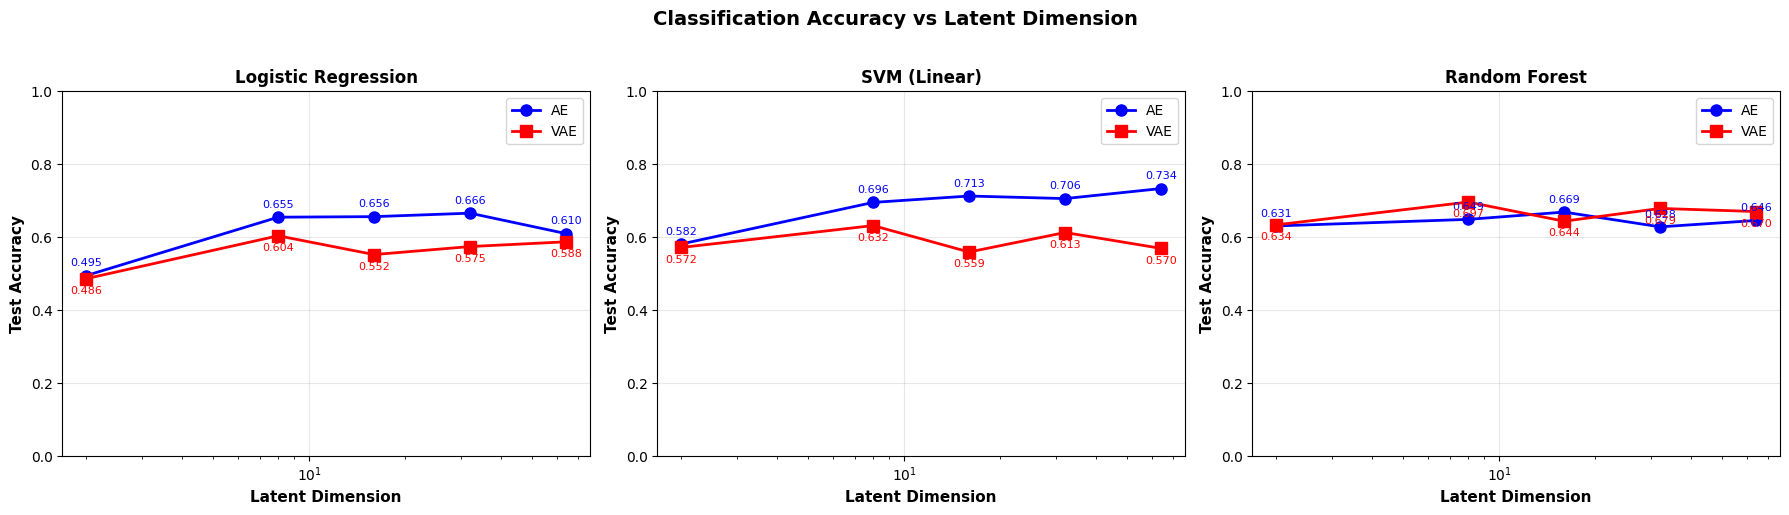

In [16]:
#Plot classification accuracy vs latent dimension for different classifiers
def evaluate_classification_across_latent_dims(ae_models, vae_models, train_loader, test_loader,
                                               device, latent_dims=[2, 8, 16, 32, 64]):
    results = {
        'latent_dims': latent_dims,
        'ae_accuracies': {},
        'vae_accuracies': {}
    }

    # We'll use Logistic Regression as the primary classifier for comparison
    classifiers_to_test = ['Logistic Regression', 'SVM (Linear)', 'Random Forest']

    for clf_name in classifiers_to_test:
        results['ae_accuracies'][clf_name] = []
        results['vae_accuracies'][clf_name] = []

    for latent_dim in latent_dims:
        print(f"Evaluating Latent Dimension = {latent_dim}")

        # Extract AE latent vectors
        print("\n[AE] Extracting latent vectors...")
        ae_train_latent, ae_train_labels, ae_test_latent, ae_test_labels = extract_latent_for_classification(
            ae_models[latent_dim], train_loader, test_loader, device,
            model_type='ae', train_samples=5000, test_samples=2000
        )

        # Extract VAE latent vectors
        print("\n[VAE] Extracting latent vectors...")
        vae_train_latent, vae_train_labels, vae_test_latent, vae_test_labels = extract_latent_for_classification(
            vae_models[latent_dim], train_loader, test_loader, device,
            model_type='vae', train_samples=5000, test_samples=2000
        )

        # Train classifiers
        ae_results = train_classifiers(ae_train_latent, ae_train_labels,
                                       ae_test_latent, ae_test_labels)

        vae_results = train_classifiers(vae_train_latent, vae_train_labels,
                                        vae_test_latent, vae_test_labels)

        # Store results
        for clf_name in classifiers_to_test:
            results['ae_accuracies'][clf_name].append(ae_results[clf_name]['test_accuracy'])
            results['vae_accuracies'][clf_name].append(vae_results[clf_name]['test_accuracy'])

    return results


def plot_classification_vs_latent_dim(results):
    latent_dims = results['latent_dims']
    classifiers = list(results['ae_accuracies'].keys())

    fig, axes = plt.subplots(1, len(classifiers), figsize=(18, 5))

    if len(classifiers) == 1:
        axes = [axes]

    for idx, clf_name in enumerate(classifiers):
        ae_acc = results['ae_accuracies'][clf_name]
        vae_acc = results['vae_accuracies'][clf_name]

        axes[idx].plot(latent_dims, ae_acc, 'o-', linewidth=2, markersize=8,
                       label='AE', color='blue')
        axes[idx].plot(latent_dims, vae_acc, 's-', linewidth=2, markersize=8,
                       label='VAE', color='red')

        axes[idx].set_xlabel('Latent Dimension', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
        axes[idx].set_title(clf_name, fontsize=12, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xscale('log')
        axes[idx].set_ylim([0, 1])

        # Add value labels
        for i, (ld, ae_val, vae_val) in enumerate(zip(latent_dims, ae_acc, vae_acc)):
            axes[idx].text(ld, ae_val + 0.02, f'{ae_val:.3f}',
                          ha='center', va='bottom', fontsize=8, color='blue')
            axes[idx].text(ld, vae_val - 0.02, f'{vae_val:.3f}',
                          ha='center', va='top', fontsize=8, color='red')

    plt.suptitle('Classification Accuracy vs Latent Dimension',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Run evaluation across different latent dimensions
print("EVALUATING CLASSIFICATION ACROSS LATENT DIMENSIONS")

classification_results = evaluate_classification_across_latent_dims(
    ae_models, vae_models, train_loader, test_loader, device,
    latent_dims=[2, 8, 16, 32, 64]
)

# Plot results
plot_classification_vs_latent_dim(classification_results)


Confusion Matrix for Logistic Regression:


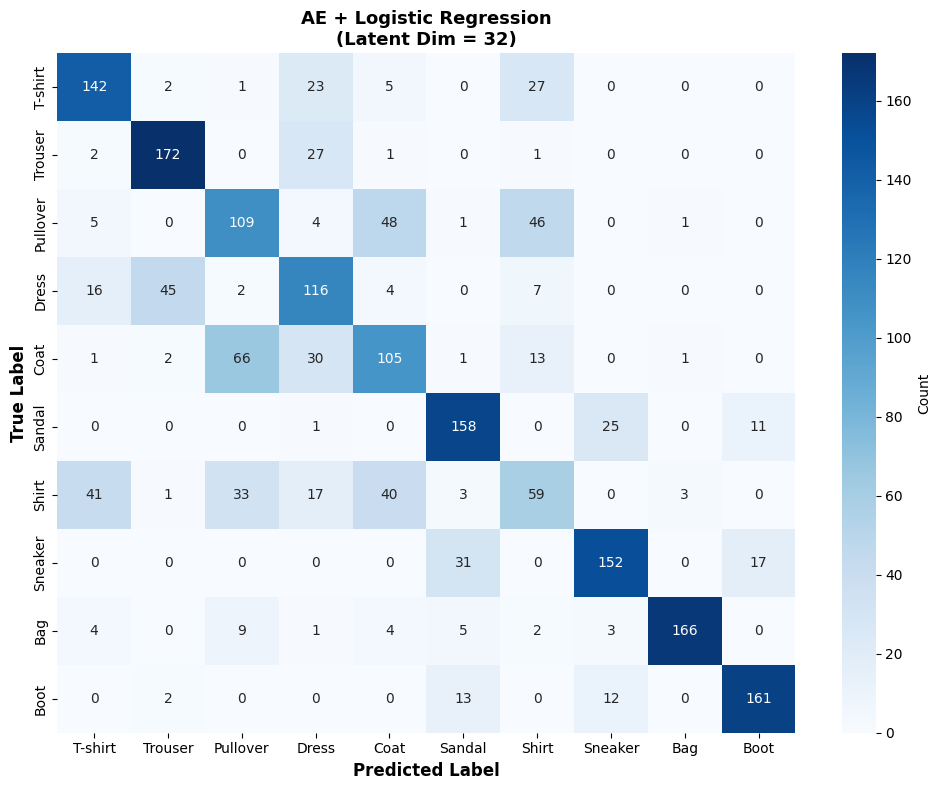

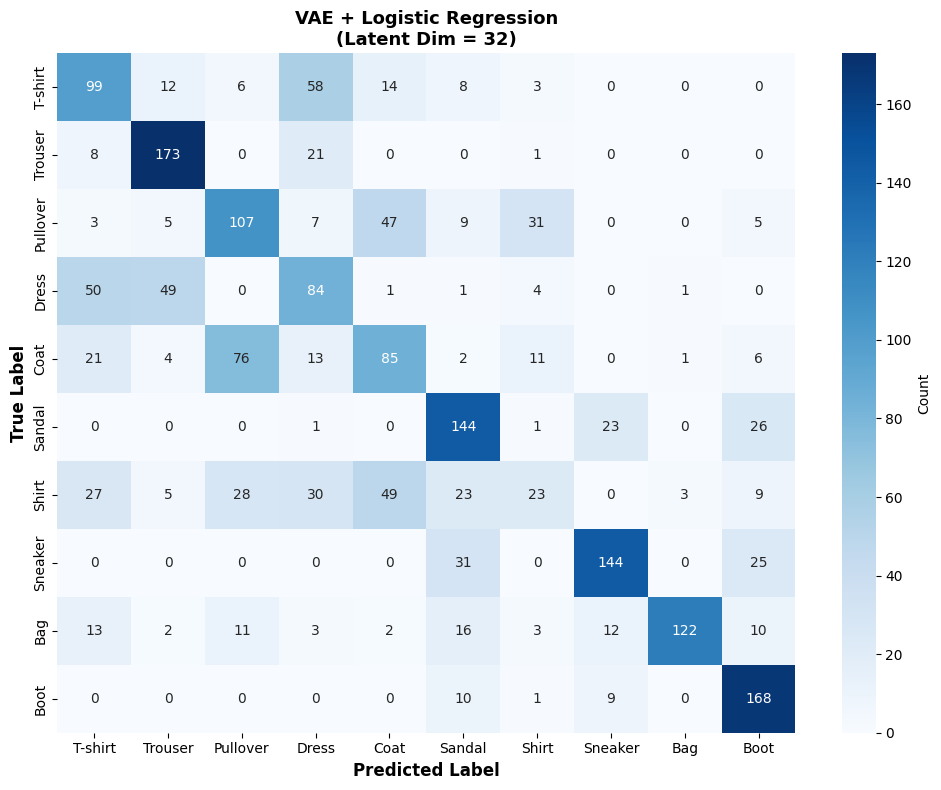

In [17]:
#confusion matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)

    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot confusion matrices for best classifier (e.g., Logistic Regression)
best_clf_name = 'Logistic Regression'

print(f"\nConfusion Matrix for {best_clf_name}:")

plot_confusion_matrix(ae_test_labels,
                     ae_classifier_results[best_clf_name]['predictions'],
                     title=f'AE + {best_clf_name}\n(Latent Dim = {latent_dim})')

plot_confusion_matrix(vae_test_labels,
                     vae_classifier_results[best_clf_name]['predictions'],
                     title=f'VAE + {best_clf_name}\n(Latent Dim = {latent_dim})')

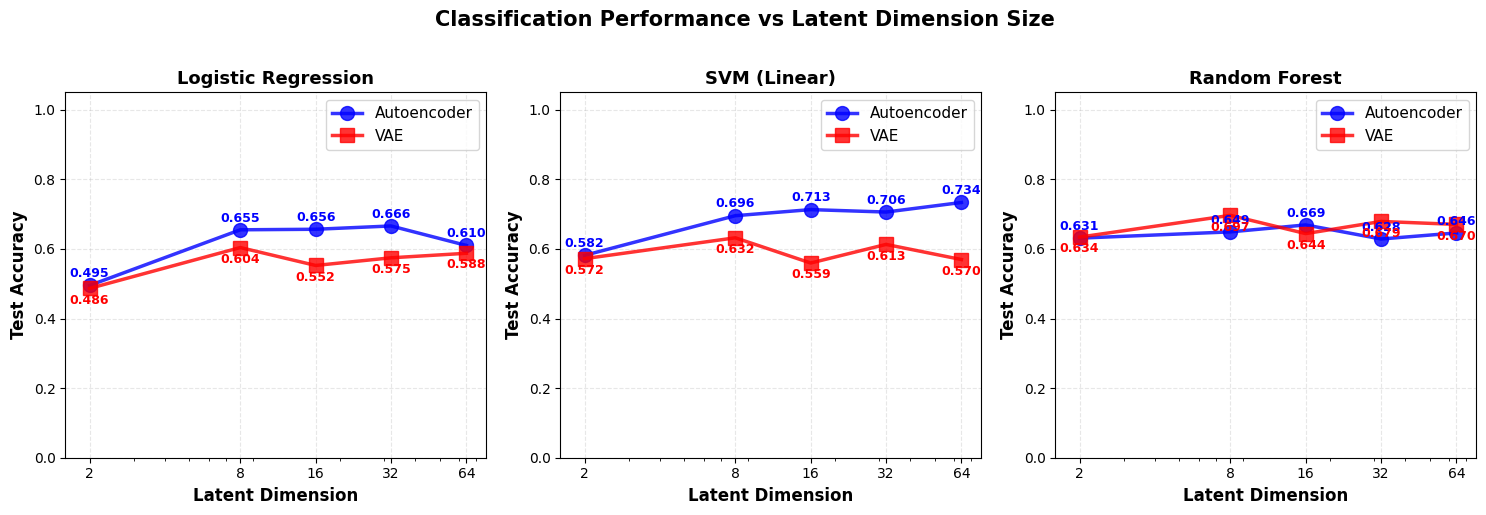

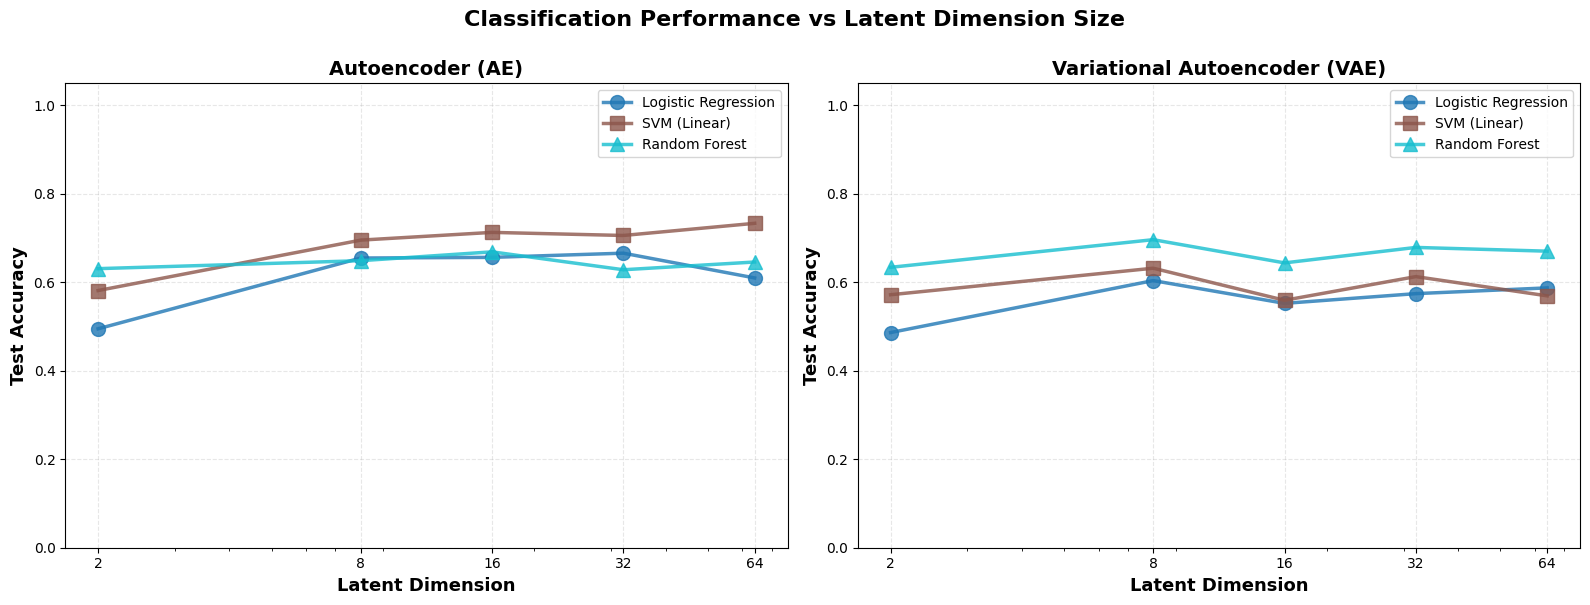

In [19]:
# graph comparing classification performance for different latent sizes
def plot_classification_vs_latent_dim(results, save_path=None):
    latent_dims = results['latent_dims']
    classifiers = list(results['ae_accuracies'].keys())

    n_classifiers = len(classifiers)

    # Create subplots (one per classifier)
    fig, axes = plt.subplots(1, n_classifiers, figsize=(5*n_classifiers, 5))

    # Handle case of single classifier
    if n_classifiers == 1:
        axes = [axes]

    for idx, clf_name in enumerate(classifiers):
        ae_acc = results['ae_accuracies'][clf_name]
        vae_acc = results['vae_accuracies'][clf_name]

        # Plot lines with markers
        axes[idx].plot(latent_dims, ae_acc, 'o-', linewidth=2.5, markersize=10,
                      label='Autoencoder', color='blue', alpha=0.8)
        axes[idx].plot(latent_dims, vae_acc, 's-', linewidth=2.5, markersize=10,
                      label='VAE', color='red', alpha=0.8)

        # Add value labels on points
        for i, (ld, ae_val, vae_val) in enumerate(zip(latent_dims, ae_acc, vae_acc)):
            axes[idx].text(ld, ae_val + 0.015, f'{ae_val:.3f}',
                          ha='center', va='bottom', fontsize=9, color='blue', fontweight='bold')
            axes[idx].text(ld, vae_val - 0.015, f'{vae_val:.3f}',
                          ha='center', va='top', fontsize=9, color='red', fontweight='bold')

        # Formatting
        axes[idx].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        axes[idx].set_title(clf_name, fontsize=13, fontweight='bold')
        axes[idx].legend(fontsize=11, loc='best')
        axes[idx].grid(True, alpha=0.3, linestyle='--')
        axes[idx].set_xscale('log')
        axes[idx].set_xticks(latent_dims)
        axes[idx].set_xticklabels(latent_dims)
        axes[idx].set_ylim([0, 1.05])
        axes[idx].set_xlim([latent_dims[0]*0.8, latent_dims[-1]*1.2])

    plt.suptitle('Classification Performance vs Latent Dimension Size',
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")

    plt.show()


def plot_classification_vs_latent_dim_single(results, save_path=None):
    latent_dims = results['latent_dims']
    classifiers = list(results['ae_accuracies'].keys())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colors = plt.cm.tab10(np.linspace(0, 1, len(classifiers)))
    markers = ['o', 's', '^', 'D', 'v', '*']

    # Plot AE results
    for idx, clf_name in enumerate(classifiers):
        ae_acc = results['ae_accuracies'][clf_name]
        axes[0].plot(latent_dims, ae_acc, marker=markers[idx % len(markers)],
                    linewidth=2.5, markersize=10, label=clf_name,
                    color=colors[idx], alpha=0.8)

    axes[0].set_xlabel('Latent Dimension', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    axes[0].set_title('Autoencoder (AE)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10, loc='best')
    axes[0].grid(True, alpha=0.3, linestyle='--')
    axes[0].set_xscale('log')
    axes[0].set_xticks(latent_dims)
    axes[0].set_xticklabels(latent_dims)
    axes[0].set_ylim([0, 1.05])

    # Plot VAE results
    for idx, clf_name in enumerate(classifiers):
        vae_acc = results['vae_accuracies'][clf_name]
        axes[1].plot(latent_dims, vae_acc, marker=markers[idx % len(markers)],
                    linewidth=2.5, markersize=10, label=clf_name,
                    color=colors[idx], alpha=0.8)

    axes[1].set_xlabel('Latent Dimension', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Variational Autoencoder (VAE)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10, loc='best')
    axes[1].grid(True, alpha=0.3, linestyle='--')
    axes[1].set_xscale('log')
    axes[1].set_xticks(latent_dims)
    axes[1].set_xticklabels(latent_dims)
    axes[1].set_ylim([0, 1.05])

    plt.suptitle('Classification Performance vs Latent Dimension Size',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()


def plot_classification_vs_latent_dim_compact(results, classifier_name='Logistic Regression', save_path=None):
    latent_dims = results['latent_dims']
    ae_acc = results['ae_accuracies'][classifier_name]
    vae_acc = results['vae_accuracies'][classifier_name]

    plt.figure(figsize=(10, 6))

    # Plot lines
    plt.plot(latent_dims, ae_acc, 'o-', linewidth=3, markersize=12,
            label='Autoencoder (AE)', color='blue', alpha=0.8)
    plt.plot(latent_dims, vae_acc, 's-', linewidth=3, markersize=12,
            label='VAE', color='red', alpha=0.8)

    # Add value labels
    for i, (ld, ae_val, vae_val) in enumerate(zip(latent_dims, ae_acc, vae_acc)):
        plt.text(ld, ae_val + 0.02, f'{ae_val:.3f}',
                ha='center', va='bottom', fontsize=10, color='blue', fontweight='bold')
        plt.text(ld, vae_val - 0.02, f'{vae_val:.3f}',
                ha='center', va='top', fontsize=10, color='red', fontweight='bold')

    plt.xlabel('Latent Dimension', fontsize=13, fontweight='bold')
    plt.ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    plt.title(f'Classification Performance vs Latent Dimension\n{classifier_name}',
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xscale('log')
    plt.xticks(latent_dims, latent_dims)
    plt.ylim([0, 1.05])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Figure saved to: {save_path}")

    plt.show()

#  Multiple subplots (one per classifier)
plot_classification_vs_latent_dim(classification_results)

#  Single plot with all classifiers, AE and VAE side-by-side
plot_classification_vs_latent_dim_single(classification_results)

# **Discussions:**


1-VAE produces a more structured latent space than AE due to:

  -KL regularization term enforcing N(0,1) distribution

  -continuous and smooth latent manifold

  -better class separation and clustering

  -ability to generate new samples



---



2-latent vectors are useful for classification because:

  -they provide compact,semantic and several feature representation

  -reduce dimensionality(computational efficient)

  -improve class separability

  -require less training data

# **Task 3:Denoising AE**

# **1)add artificial noise to images**

In [ ]:
#add gaussian noise
def add_gaussian_noise(images, noise_level=0.3):
    noise = torch.randn_like(images) * noise_level
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
    return noisy_images

In [ ]:
#add salt-and-pepper noise
def add_salt_pepper_noise(images, noise_prob=0.1):
    noisy_images = images.clone()

    # Salt noise (white pixels)
    salt_mask = torch.rand_like(images) < (noise_prob / 2)
    noisy_images[salt_mask] = 1.0

    # Pepper noise (black pixels)
    pepper_mask = torch.rand_like(images) < (noise_prob / 2)
    noisy_images[pepper_mask] = 0.0

    return noisy_images

In [ ]:
#Visualize different types of noise
def visualize_noise_types():
    # Get a sample image
    images, _ = next(iter(test_loader))
    clean_image = images[0:1]

    # Different noise levels
    gaussian_levels = [0.1, 0.3, 0.5]
    sp_levels = [0.05, 0.15, 0.3]

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))

    # Clean image
    axes[0, 0].imshow(clean_image[0, 0].numpy(), cmap='gray')
    axes[0, 0].set_title('Clean Image', fontweight='bold')
    axes[0, 0].axis('off')

    axes[1, 0].imshow(clean_image[0, 0].numpy(), cmap='gray')
    axes[1, 0].set_title('Clean Image', fontweight='bold')
    axes[1, 0].axis('off')

    axes[2, 0].axis('off')

    # Gaussian noise
    for i, level in enumerate(gaussian_levels):
        noisy = add_gaussian_noise(clean_image, noise_level=level)
        axes[0, i+1].imshow(noisy[0, 0].numpy(), cmap='gray')
        axes[0, i+1].set_title(f'Gaussian σ={level}', fontweight='bold')
        axes[0, i+1].axis('off')

    # Salt-and-pepper noise
    for i, prob in enumerate(sp_levels):
        noisy = add_salt_pepper_noise(clean_image, noise_prob=prob)
        axes[1, i+1].imshow(noisy[0, 0].numpy(), cmap='gray')
        axes[1, i+1].set_title(f'Salt&Pepper p={prob}', fontweight='bold')
        axes[1, i+1].axis('off')

    # Hide unused subplots
    for i in range(4):
        axes[2, i].axis('off')

    plt.suptitle('Noise Types and Levels', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize noise types
print("Visualizing noise types...")
visualize_noise_types()

# **2) Denoising Autoencoder Architecture**

In [ ]:
class DenoisingAutoencoder(nn.Module):
    #Denoising Autoencoder based on the ConvAutoEncoder architecture
    #Can be trained to denoise images
    def __init__(self, latent_dim=64):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder (same as before)
        self.encoder = nn.Sequential(
            # Block 1: 28x28 -> 14x14
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2: 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3: 7x7 -> 3x3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 4: 3x3 -> 1x1
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 3),
        )

        # Bottleneck
        self.flatten = nn.Flatten()
        self.fc_encoder = nn.Sequential(
            nn.Linear(512 * 1 * 1, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, latent_dim)
        )

        # Decoder bottleneck
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512 * 1 * 1),
            nn.ReLU(inplace=True)
        )
        self.unflatten = nn.Unflatten(1, (512, 1, 1))

        # Decoder
        self.decoder = nn.Sequential(
            # Block 1: 1x1 -> 3x3
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Block 2: 3x3 -> 7x7
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Block 3: 7x7 -> 14x14
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 4: 14x14 -> 28x28
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Final layer
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc_encoder(x)
        return x

    def decode(self, z):
        x = self.fc_decoder(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

In [ ]:
#training loop for denoising
def train_denoising_autoencoder(model, train_loader, test_loader, epochs, lr, device,
                                noise_type='gaussian', noise_level=0.3):
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_psnr': [],
        'test_psnr': []
    }

    def compute_psnr(img1, img2):
        #Compute Peak Signal-to-Noise Ratio
        mse = nn.functional.mse_loss(img1, img2)
        if mse == 0:
            return float('inf')
        psnr = 10 * torch.log10(1.0 / mse)
        return psnr.item()

    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_loss = 0.0
        train_psnr = 0.0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for batch_idx, (clean_images, _) in enumerate(train_pbar):
            clean_images = clean_images.to(device)

            # Add noise to images
            if noise_type == 'gaussian':
                noisy_images = add_gaussian_noise(clean_images, noise_level)
            elif noise_type == 'salt_pepper':
                noisy_images = add_salt_pepper_noise(clean_images, noise_level)
            else:
                raise ValueError("noise_type must be 'gaussian' or 'salt_pepper'")

            noisy_images = noisy_images.to(device)

            # Forward pass: input is noisy, target is clean
            denoised, _ = model(noisy_images)

            # Compute loss (reconstruct clean from noisy)
            loss = criterion(denoised, clean_images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            train_psnr += compute_psnr(denoised, clean_images)

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

        # Average training metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_train_psnr = train_psnr / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['train_psnr'].append(avg_train_psnr)

        #Validation Phase
        model.eval()
        test_loss = 0.0
        test_psnr = 0.0

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')

            for clean_images, _ in test_pbar:
                clean_images = clean_images.to(device)

                # Add noise
                if noise_type == 'gaussian':
                    noisy_images = add_gaussian_noise(clean_images, noise_level)
                elif noise_type == 'salt_pepper':
                    noisy_images = add_salt_pepper_noise(clean_images, noise_level)

                noisy_images = noisy_images.to(device)

                # Forward pass
                denoised, _ = model(noisy_images)

                # Compute loss
                loss = criterion(denoised, clean_images)
                test_loss += loss.item()
                test_psnr += compute_psnr(denoised, clean_images)

                test_pbar.set_postfix({'loss': loss.item()})

        # Average test metrics
        avg_test_loss = test_loss / len(test_loader)
        avg_test_psnr = test_psnr / len(test_loader)
        history['test_loss'].append(avg_test_loss)
        history['test_psnr'].append(avg_test_psnr)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'  Train - Loss: {avg_train_loss:.6f}, PSNR: {avg_train_psnr:.2f} dB')
        print(f'  Test  - Loss: {avg_test_loss:.6f}, PSNR: {avg_test_psnr:.2f} dB')

    return history


# Example: Train a denoising autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Configuration
latent_dim = 64
lr = 1e-3
epochs = 20
noise_type = 'gaussian'  # or 'salt_pepper'
noise_level = 0.3

print(f"Training Denoising Autoencoder")
print(f"Noise type: {noise_type}, Level: {noise_level}")

# Initialize and train model
dae_model = DenoisingAutoencoder(latent_dim=latent_dim).to(device)

dae_history = train_denoising_autoencoder(
    model=dae_model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=epochs,
    lr=lr,
    device=device,
    noise_type=noise_type,
    noise_level=noise_level
)

# Save model
drive_dir = "/content/drive/MyDrive/Computer Vision/assignment1/models"
dae_path = os.path.join(drive_dir, f"dae_{noise_type}_level{noise_level}.pth")
torch.save({
    "model_state_dict": dae_model.state_dict(),
    "latent_dim": latent_dim,
    "noise_type": noise_type,
    "noise_level": noise_level,
    "epoch": epochs,
    "history": dae_history
}, dae_path)

print(f"\ Model saved to: {dae_path}")

# **Plot 1:Training curves vs epochs**

In [ ]:
#Plot training curves for denoising autoencoder
def plot_denoising_training_curves(history, noise_type, noise_level):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs_range = range(1, len(history['train_loss']) + 1)

    # Loss curve
    axes[0].plot(epochs_range, history['train_loss'], 'b-',
                label='Train Loss', linewidth=2)
    axes[0].plot(epochs_range, history['test_loss'], 'r-',
                label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Loss vs Epoch', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # PSNR curve (higher is better)
    axes[1].plot(epochs_range, history['train_psnr'], 'b-',
                label='Train PSNR', linewidth=2)
    axes[1].plot(epochs_range, history['test_psnr'], 'r-',
                label='Test PSNR', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
    axes[1].set_title('PSNR vs Epoch (Higher = Better)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle(f'Denoising Autoencoder Training\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Plot training curves
plot_denoising_training_curves(dae_history, noise_type, noise_level)

# **Visual Comparison (Clean vs Noisy vs Denoised)**

In [ ]:
def visualize_denoising_results(model, test_loader, device, noise_type, noise_level, num_images=10):
    model.eval()

    # Get test images
    clean_images, _ = next(iter(test_loader))
    clean_images = clean_images[:num_images].to(device)

    # Add noise
    if noise_type == 'gaussian':
        noisy_images = add_gaussian_noise(clean_images, noise_level)
    elif noise_type == 'salt_pepper':
        noisy_images = add_salt_pepper_noise(clean_images, noise_level)

    # Denoise
    with torch.no_grad():
        denoised_images, _ = model(noisy_images)

    # Create visualization
    fig, axes = plt.subplots(3, num_images, figsize=(num_images*1.5, 4.5))

    for i in range(num_images):
        # Clean image
        axes[0, i].imshow(clean_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Clean', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

        # Noisy image
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Noisy', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

        # Denoised image
        axes[2, i].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_ylabel('Denoised', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

    plt.suptitle(f'Denoising Results\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize results
visualize_denoising_results(dae_model, test_loader, device, noise_type, noise_level, num_images=10)

# **4)Denoising autoencoders for different noise levels**

In [ ]:
#Train denoising autoencoders for different noise levels
def train_models_for_different_noise_levels(train_loader, test_loader, device,
                                            noise_type='gaussian',
                                            noise_levels=[0.1, 0.2, 0.3, 0.4, 0.5],
                                            latent_dim=64, lr=1e-3, epochs=20):
    models = {}
    histories = {}

    for noise_level in noise_levels:
        print(f"\n{'='*70}")
        print(f"Training with {noise_type} noise, level = {noise_level}")
        print(f"{'='*70}\n")

        # Initialize model
        model = DenoisingAutoencoder(latent_dim=latent_dim).to(device)

        # Train
        history = train_denoising_autoencoder(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            device=device,
            noise_type=noise_type,
            noise_level=noise_level
        )

        # Save
        models[noise_level] = model
        histories[noise_level] = history

        # Save to disk
        save_path = os.path.join(drive_dir, f"dae_{noise_type}_level{noise_level}.pth")
        torch.save({
            "model_state_dict": model.state_dict(),
            "latent_dim": latent_dim,
            "noise_type": noise_type,
            "noise_level": noise_level,
            "epoch": epochs,
            "history": history
        }, save_path)

        print(f"✓ Saved: {save_path}")

    return models, histories


# Train models for different Gaussian noise levels
print("TRAINING DENOISING AUTOENCODERS FOR MULTIPLE NOISE LEVELS")

gaussian_noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

gaussian_models, gaussian_histories = train_models_for_different_noise_levels(
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    noise_type='gaussian',
    noise_levels=gaussian_noise_levels,
    latent_dim=64,
    lr=1e-3,
    epochs=20
)

#  also train for salt-and-pepper noise
sp_noise_levels = [0.05, 0.10, 0.15, 0.20, 0.30]

sp_models, sp_histories = train_models_for_different_noise_levels(
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    noise_type='salt_pepper',
    noise_levels=sp_noise_levels,
    latent_dim=64,
    lr=1e-3,
    epochs=20
)

# **Plot 2:Denoising performance vs noisy level**

In [ ]:
#Evaluate denoising performance for different noise levels
def evaluate_denoising_performance(models, test_loader, device, noise_type, noise_levels):
    results = {
        'noise_levels': noise_levels,
        'mse': [],
        'psnr': [],
        'ssim': []
    }

    from skimage.metrics import structural_similarity as ssim

    for noise_level in noise_levels:
        model = models[noise_level]
        model.eval()

        total_mse = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
        num_batches = 0

        with torch.no_grad():
            for clean_images, _ in test_loader:
                clean_images = clean_images.to(device)

                # Add noise
                if noise_type == 'gaussian':
                    noisy_images = add_gaussian_noise(clean_images, noise_level)
                elif noise_type == 'salt_pepper':
                    noisy_images = add_salt_pepper_noise(clean_images, noise_level)

                # Denoise
                denoised_images, _ = model(noisy_images)

                # Compute metrics
                mse = nn.functional.mse_loss(denoised_images, clean_images).item()
                psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

                # SSIM (for first image in batch)
                clean_np = clean_images[0, 0].cpu().numpy()
                denoised_np = denoised_images[0, 0].cpu().numpy()
                ssim_val = ssim(clean_np, denoised_np, data_range=1.0)

                total_mse += mse
                total_psnr += psnr
                total_ssim += ssim_val
                num_batches += 1

        # Average metrics
        avg_mse = total_mse / num_batches
        avg_psnr = total_psnr / num_batches
        avg_ssim = total_ssim / num_batches

        results['mse'].append(avg_mse)
        results['psnr'].append(avg_psnr)
        results['ssim'].append(avg_ssim)

        print(f"Noise Level {noise_level:.2f}: MSE={avg_mse:.6f}, PSNR={avg_psnr:.2f} dB, SSIM={avg_ssim:.4f}")

    return results

# Plot denoising performance vs noise level
def plot_performance_vs_noise_level(results, noise_type):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    noise_levels = results['noise_levels']

    # MSE (lower is better)
    axes[0].plot(noise_levels, results['mse'], 'o-', linewidth=2.5, markersize=10, color='red')
    axes[0].set_xlabel('Noise Level', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('MSE (Lower = Better)', fontsize=12, fontweight='bold')
    axes[0].set_title('Mean Squared Error', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Add value labels
    for x, y in zip(noise_levels, results['mse']):
        axes[0].text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=9)

    # PSNR (higher is better)
    axes[1].plot(noise_levels, results['psnr'], 'o-', linewidth=2.5, markersize=10, color='blue')
    axes[1].set_xlabel('Noise Level', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('PSNR (dB) (Higher = Better)', fontsize=12, fontweight='bold')
    axes[1].set_title('Peak Signal-to-Noise Ratio', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Add value labels
    for x, y in zip(noise_levels, results['psnr']):
        axes[1].text(x, y, f'{y:.1f}', ha='center', va='bottom', fontsize=9)

    # SSIM (higher is better)
    axes[2].plot(noise_levels, results['ssim'], 'o-', linewidth=2.5, markersize=10, color='green')
    axes[2].set_xlabel('Noise Level', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('SSIM (Higher = Better)', fontsize=12, fontweight='bold')
    axes[2].set_title('Structural Similarity Index', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1])

    # Add value labels
    for x, y in zip(noise_levels, results['ssim']):
        axes[2].text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle(f'Denoising Performance vs Noise Level\n{noise_type.replace("_", " ").title()} Noise',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


# Evaluate and plot for Gaussian noise
print("EVALUATING DENOISING PERFORMANCE - GAUSSIAN NOISE")

gaussian_results = evaluate_denoising_performance(
    gaussian_models, test_loader, device, 'gaussian', gaussian_noise_levels
)

plot_performance_vs_noise_level(gaussian_results, 'gaussian')

# Evaluate and plot for Salt-and-Pepper noise
print("EVALUATING DENOISING PERFORMANCE - SALT-AND-PEPPER NOISE")

sp_results = evaluate_denoising_performance(
    sp_models, test_loader, device, 'salt_pepper', sp_noise_levels
)

plot_performance_vs_noise_level(sp_results, 'salt_pepper')

In [ ]:
#Compare denoising results across different noise levels
def compare_denoising_across_noise_levels(models, test_loader, device, noise_type, noise_levels):
    # Get one test image
    clean_images, _ = next(iter(test_loader))
    clean_image = clean_images[0:1].to(device)

    num_levels = len(noise_levels)
    fig, axes = plt.subplots(3, num_levels + 1, figsize=((num_levels + 1)*1.8, 5.5))

    # Clean image column
    for row in range(3):
        axes[row, 0].imshow(clean_image[0].cpu().squeeze(), cmap='gray')
        axes[row, 0].axis('off')
        if row == 0:
            axes[row, 0].set_title('Clean\nOriginal', fontsize=10, fontweight='bold')

    axes[0, 0].set_ylabel('Clean', fontsize=11, fontweight='bold', rotation=0, labelpad=40)
    axes[1, 0].set_ylabel('Noisy', fontsize=11, fontweight='bold', rotation=0, labelpad=40)
    axes[2, 0].set_ylabel('Denoised', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

    # For each noise level
    for col_idx, noise_level in enumerate(noise_levels, start=1):
        model = models[noise_level]
        model.eval()

        # Add noise
        if noise_type == 'gaussian':
            noisy_image = add_gaussian_noise(clean_image, noise_level)
        elif noise_type == 'salt_pepper':
            noisy_image = add_salt_pepper_noise(clean_image, noise_level)

        # Denoise
        with torch.no_grad():
            denoised_image, _ = model(noisy_image)

        # Compute PSNR
        psnr_noisy = 10 * np.log10(1.0 / nn.functional.mse_loss(noisy_image, clean_image).item())
        psnr_denoised = 10 * np.log10(1.0 / nn.functional.mse_loss(denoised_image, clean_image).item())

        # Plot clean (for reference)
        axes[0, col_idx].imshow(clean_image[0].cpu().squeeze(), cmap='gray')
        axes[0, col_idx].axis('off')
        axes[0, col_idx].set_title(f'Level={noise_level}', fontsize=10, fontweight='bold')

        # Plot noisy
        axes[1, col_idx].imshow(noisy_image[0].cpu().squeeze(), cmap='gray')
        axes[1, col_idx].axis('off')
        axes[1, col_idx].text(0.5, -0.1, f'PSNR: {psnr_noisy:.1f} dB',
                             transform=axes[1, col_idx].transAxes,
                             ha='center', fontsize=8, color='red')

        # Plot denoised
        axes[2, col_idx].imshow(denoised_image[0].cpu().squeeze(), cmap='gray')
        axes[2, col_idx].axis('off')
        axes[2, col_idx].text(0.5, -0.1, f'PSNR: {psnr_denoised:.1f} dB',
                             transform=axes[2, col_idx].transAxes,
                             ha='center', fontsize=8, color='green')

    plt.suptitle(f'Denoising Comparison Across Noise Levels\n{noise_type.replace("_", " ").title()} Noise',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize comparison for Gaussian noise
compare_denoising_across_noise_levels(
    gaussian_models, test_loader, device, 'gaussian', gaussian_noise_levels
)

# Visualize comparison for Salt-and-Pepper noise
compare_denoising_across_noise_levels(
    sp_models, test_loader, device, 'salt_pepper', sp_noise_levels
)

# **3)test denoising model on unseen noisy test data**

In [ ]:
#Show denoising results for multiple test images
def visualize_multiple_denoising_examples(model, test_loader, device, noise_type, noise_level, num_images=8):
    model.eval()

    # Get test images
    clean_images, _ = next(iter(test_loader))
    clean_images = clean_images[:num_images].to(device)

    # Add noise
    if noise_type == 'gaussian':
        noisy_images = add_gaussian_noise(clean_images, noise_level)
    elif noise_type == 'salt_pepper':
        noisy_images = add_salt_pepper_noise(clean_images, noise_level)

    # Denoise
    with torch.no_grad():
        denoised_images, _ = model(noisy_images)

    # Create visualization
    fig, axes = plt.subplots(3, num_images, figsize=(num_images*1.5, 4.5))

    for i in range(num_images):
        # Compute metrics
        psnr_noisy = 10 * np.log10(1.0 / nn.functional.mse_loss(noisy_images[i:i+1], clean_images[i:i+1]).item())
        psnr_denoised = 10 * np.log10(1.0 / nn.functional.mse_loss(denoised_images[i:i+1], clean_images[i:i+1]).item())

        # Clean
        axes[0, i].imshow(clean_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Clean', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

        # Noisy
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'{psnr_noisy:.1f} dB', fontsize=9, color='red')
        if i == 0:
            axes[1, i].set_ylabel('Noisy', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

        # Denoised
        axes[2, i].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'{psnr_denoised:.1f} dB', fontsize=9, color='green')
        if i == 0:
            axes[2, i].set_ylabel('Denoised', fontsize=11, fontweight='bold', rotation=0, labelpad=40)

    plt.suptitle(f'Denoising Results - Multiple Examples\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize multiple examples
visualize_multiple_denoising_examples(
    gaussian_models[0.3], test_loader, device, 'gaussian', 0.3, num_images=8
)

visualize_multiple_denoising_examples(
    sp_models[0.15], test_loader, device, 'salt_pepper', 0.15, num_images=8
)

# **Discussions:**
1-when the level becomes too high,several degradation effects occur:

-the model struggles to find meaningful patterns

-denoised images lose fine details

-the model may learn to output smoothed versions rather than sharper features

-prevent the model from learning useful representations


2-compare denoising results for different latent sizes==> code implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import os

# Train Models with Different Latent Dimensions
def train_models_for_different_latent_dims(train_loader, test_loader, device,
                                          latent_dims=[16, 32, 64, 128, 256],
                                          noise_type='gaussian',
                                          noise_level=0.3,
                                          lr=1e-3,
                                          epochs=20):
    models = {}
    histories = {}

    for latent_dim in latent_dims:
        print(f"Training with latent_dim = {latent_dim}")

        # Initialize model
        model = DenoisingAutoencoder(latent_dim=latent_dim).to(device)

        # Train
        history = train_denoising_autoencoder(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            device=device,
            noise_type=noise_type,
            noise_level=noise_level
        )

        # Save
        models[latent_dim] = model
        histories[latent_dim] = history

        # Save to disk
        save_path = os.path.join(drive_dir,
                                f"dae_{noise_type}_level{noise_level}_latent{latent_dim}.pth")
        torch.save({
            "model_state_dict": model.state_dict(),
            "latent_dim": latent_dim,
            "noise_type": noise_type,
            "noise_level": noise_level,
            "epoch": epochs,
            "history": history
        }, save_path)

        print(f"Saved: {save_path}")

    return models, histories


# STEP 2: Evaluate Performance for Different Latent Dimensions
def evaluate_latent_dim_performance(models, test_loader, device,
                                   noise_type, noise_level, latent_dims):
    results = {
        'latent_dims': latent_dims,
        'mse': [],
        'psnr': [],
        'ssim': [],
        'param_count': [],
        'compression_ratio': []
    }

    for latent_dim in latent_dims:
        model = models[latent_dim]
        model.eval()

        # Count parameters
        param_count = sum(p.numel() for p in model.parameters())
        compression_ratio = 784 / latent_dim  # 28*28 / latent_dim

        total_mse = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
        num_batches = 0

        with torch.no_grad():
            for clean_images, _ in test_loader:
                clean_images = clean_images.to(device)

                # Add noise
                if noise_type == 'gaussian':
                    noisy_images = add_gaussian_noise(clean_images, noise_level)
                elif noise_type == 'salt_pepper':
                    noisy_images = add_salt_pepper_noise(clean_images, noise_level)

                # Denoise
                denoised_images, _ = model(noisy_images)

                # Compute metrics
                mse = nn.functional.mse_loss(denoised_images, clean_images).item()
                psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

                # SSIM (average over batch)
                batch_ssim = 0.0
                for i in range(clean_images.size(0)):
                    clean_np = clean_images[i, 0].cpu().numpy()
                    denoised_np = denoised_images[i, 0].cpu().numpy()
                    batch_ssim += ssim(clean_np, denoised_np, data_range=1.0)
                batch_ssim /= clean_images.size(0)

                total_mse += mse
                total_psnr += psnr
                total_ssim += batch_ssim
                num_batches += 1

        # Average metrics
        avg_mse = total_mse / num_batches
        avg_psnr = total_psnr / num_batches
        avg_ssim = total_ssim / num_batches

        results['mse'].append(avg_mse)
        results['psnr'].append(avg_psnr)
        results['ssim'].append(avg_ssim)
        results['param_count'].append(param_count)
        results['compression_ratio'].append(compression_ratio)

        print(f"\nLatent Dim {latent_dim}:")
        print(f"  MSE: {avg_mse:.6f}")
        print(f"  PSNR: {avg_psnr:.2f} dB")
        print(f"  SSIM: {avg_ssim:.4f}")
        print(f"  Parameters: {param_count:,}")
        print(f"  Compression Ratio: {compression_ratio:.1f}x")

    return results

# Plot Performance vs Latent Dimension
def plot_performance_vs_latent_dim(results, noise_type, noise_level):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    latent_dims = results['latent_dims']

    # Plot 1: MSE (lower is better)
    axes[0, 0].plot(latent_dims, results['mse'], 'o-',
                   linewidth=2.5, markersize=10, color='red')
    axes[0, 0].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('MSE (Lower = Better)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Mean Squared Error vs Latent Dimension',
                        fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xscale('log', base=2)

    # Add value labels
    for x, y in zip(latent_dims, results['mse']):
        axes[0, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)

    # Plot 2: PSNR (higher is better)
    axes[0, 1].plot(latent_dims, results['psnr'], 'o-',
                   linewidth=2.5, markersize=10, color='blue')
    axes[0, 1].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('PSNR (dB) (Higher = Better)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Peak Signal-to-Noise Ratio vs Latent Dimension',
                        fontsize=13, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xscale('log', base=2)

    # Add value labels
    for x, y in zip(latent_dims, results['psnr']):
        axes[0, 1].text(x, y, f'{y:.1f}', ha='center', va='bottom', fontsize=8)

    # Plot 3: SSIM (higher is better)
    axes[1, 0].plot(latent_dims, results['ssim'], 'o-',
                   linewidth=2.5, markersize=10, color='green')
    axes[1, 0].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('SSIM (Higher = Better)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Structural Similarity Index vs Latent Dimension',
                        fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].set_xscale('log', base=2)

    # Add value labels
    for x, y in zip(latent_dims, results['ssim']):
        axes[1, 0].text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=8)

    # Plot 4: Model Complexity (Parameter Count)
    axes[1, 1].plot(latent_dims, results['param_count'], 'o-',
                   linewidth=2.5, markersize=10, color='purple')
    axes[1, 1].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Model Complexity vs Latent Dimension',
                        fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xscale('log', base=2)

    # Add value labels
    for x, y in zip(latent_dims, results['param_count']):
        axes[1, 1].text(x, y, f'{y/1e6:.2f}M', ha='center', va='bottom', fontsize=8)

    plt.suptitle(f'Denoising Performance vs Latent Dimension\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


# Visual Comparison Across Latent Dimensions
def compare_latent_dims_visual(models, test_loader, device,
                               noise_type, noise_level, latent_dims):
    # Get one test image
    clean_images, _ = next(iter(test_loader))
    clean_image = clean_images[0:1].to(device)

    # Add noise
    if noise_type == 'gaussian':
        noisy_image = add_gaussian_noise(clean_image, noise_level)
    elif noise_type == 'salt_pepper':
        noisy_image = add_salt_pepper_noise(clean_image, noise_level)

    num_latents = len(latent_dims)
    fig, axes = plt.subplots(2, num_latents + 1, figsize=((num_latents + 1)*2, 4.5))

    # Column 0: Clean and Noisy reference
    axes[0, 0].imshow(clean_image[0].cpu().squeeze(), cmap='gray')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Clean\nOriginal', fontsize=10, fontweight='bold')

    axes[1, 0].imshow(noisy_image[0].cpu().squeeze(), cmap='gray')
    axes[1, 0].axis('off')

    # Compute noisy PSNR
    psnr_noisy = 10 * np.log10(1.0 / nn.functional.mse_loss(noisy_image, clean_image).item())
    axes[1, 0].set_title(f'Noisy\nPSNR: {psnr_noisy:.1f} dB',
                        fontsize=10, fontweight='bold', color='red')

    # For each latent dimension
    for col_idx, latent_dim in enumerate(latent_dims, start=1):
        model = models[latent_dim]
        model.eval()

        # Denoise
        with torch.no_grad():
            denoised_image, _ = model(noisy_image)

        # Compute metrics
        psnr = 10 * np.log10(1.0 / nn.functional.mse_loss(denoised_image, clean_image).item())
        ssim_val = ssim(clean_image[0, 0].cpu().numpy(),
                       denoised_image[0, 0].cpu().numpy(),
                       data_range=1.0)

        # Top row: Clean reference
        axes[0, col_idx].imshow(clean_image[0].cpu().squeeze(), cmap='gray')
        axes[0, col_idx].axis('off')
        axes[0, col_idx].set_title(f'Latent={latent_dim}',
                                   fontsize=10, fontweight='bold')

        # Bottom row: Denoised
        axes[1, col_idx].imshow(denoised_image[0].cpu().squeeze(), cmap='gray')
        axes[1, col_idx].axis('off')
        axes[1, col_idx].set_title(f'PSNR: {psnr:.1f} dB\nSSIM: {ssim_val:.3f}',
                                   fontsize=9, color='green')

    plt.suptitle(f'Denoising Comparison: Different Latent Dimensions\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# STEP 5: Compare Multiple Images Across Latent Dimensions
def compare_multiple_images_latent_dims(models, test_loader, device,
                                       noise_type, noise_level,
                                       latent_dims, num_images=5):
    # Get test images
    clean_images, _ = next(iter(test_loader))
    clean_images = clean_images[:num_images].to(device)

    # Add noise
    if noise_type == 'gaussian':
        noisy_images = add_gaussian_noise(clean_images, noise_level)
    elif noise_type == 'salt_pepper':
        noisy_images = add_salt_pepper_noise(clean_images, noise_level)

    num_latents = len(latent_dims)
    fig, axes = plt.subplots(num_images, num_latents + 2,
                            figsize=((num_latents + 2)*1.8, num_images*1.8))

    for img_idx in range(num_images):
        clean_img = clean_images[img_idx:img_idx+1]
        noisy_img = noisy_images[img_idx:img_idx+1]

        # Column 0: Clean
        axes[img_idx, 0].imshow(clean_img[0].cpu().squeeze(), cmap='gray')
        axes[img_idx, 0].axis('off')
        if img_idx == 0:
            axes[img_idx, 0].set_title('Clean', fontsize=10, fontweight='bold')

        # Column 1: Noisy
        axes[img_idx, 1].imshow(noisy_img[0].cpu().squeeze(), cmap='gray')
        axes[img_idx, 1].axis('off')
        if img_idx == 0:
            axes[img_idx, 1].set_title('Noisy', fontsize=10, fontweight='bold')

        # Columns 2+: Denoised with different latent dims
        for col_idx, latent_dim in enumerate(latent_dims, start=2):
            model = models[latent_dim]
            model.eval()

            with torch.no_grad():
                denoised_img, _ = model(noisy_img)

            # Compute PSNR
            psnr = 10 * np.log10(1.0 / nn.functional.mse_loss(denoised_img, clean_img).item())

            axes[img_idx, col_idx].imshow(denoised_img[0].cpu().squeeze(), cmap='gray')
            axes[img_idx, col_idx].axis('off')

            if img_idx == 0:
                axes[img_idx, col_idx].set_title(f'Latent={latent_dim}',
                                                fontsize=10, fontweight='bold')

            # Add PSNR as text
            axes[img_idx, col_idx].text(0.5, -0.1, f'{psnr:.1f} dB',
                                       transform=axes[img_idx, col_idx].transAxes,
                                       ha='center', fontsize=8, color='green')

    plt.suptitle(f'Multiple Images Comparison: Latent Dimensions\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Training Curves Comparison
def plot_training_curves_comparison(histories, latent_dims, noise_type, noise_level):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    colors = plt.cm.viridis(np.linspace(0, 1, len(latent_dims)))

    # Plot 1: Loss curves
    for idx, latent_dim in enumerate(latent_dims):
        history = histories[latent_dim]
        epochs_range = range(1, len(history['train_loss']) + 1)

        axes[0].plot(epochs_range, history['test_loss'],
                    color=colors[idx], linewidth=2,
                    label=f'Latent={latent_dim}', marker='o', markersize=4)

    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Test MSE Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Test Loss vs Epoch (Different Latent Dims)',
                     fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: PSNR curves
    for idx, latent_dim in enumerate(latent_dims):
        history = histories[latent_dim]
        epochs_range = range(1, len(history['test_psnr']) + 1)

        axes[1].plot(epochs_range, history['test_psnr'],
                    color=colors[idx], linewidth=2,
                    label=f'Latent={latent_dim}', marker='o', markersize=4)

    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Test PSNR (dB)', fontsize=12, fontweight='bold')
    axes[1].set_title('Test PSNR vs Epoch (Different Latent Dims)',
                     fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle(f'Training Curves Comparison\n{noise_type.replace("_", " ").title()} Noise (Level={noise_level})',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


# Summary Table
def print_latent_dim_summary_table(results):
    print("LATENT DIMENSION COMPARISON SUMMARY")
    print(f"{'Latent Dim':<12} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<10} {'Params':<15} {'Compression':<12}")

    for i, latent_dim in enumerate(results['latent_dims']):
        print(f"{latent_dim:<12} "
              f"{results['mse'][i]:<12.6f} "
              f"{results['psnr'][i]:<12.2f} "
              f"{results['ssim'][i]:<10.4f} "
              f"{results['param_count'][i]:>10,}   "
              f"{results['compression_ratio'][i]:<12.1f}x")


    # Find best performers
    best_psnr_idx = np.argmax(results['psnr'])
    best_ssim_idx = np.argmax(results['ssim'])
    smallest_model_idx = np.argmin(results['param_count'])

    print("\nKey Findings:")
    print(f"  Best PSNR: Latent Dim = {results['latent_dims'][best_psnr_idx]} "
          f"({results['psnr'][best_psnr_idx]:.2f} dB)")
    print(f"  Best SSIM: Latent Dim = {results['latent_dims'][best_ssim_idx]} "
          f"({results['ssim'][best_ssim_idx]:.4f})")
    print(f"   Smallest Model: Latent Dim = {results['latent_dims'][smallest_model_idx]} "
          f"({results['param_count'][smallest_model_idx]:,} params)")


#  Complete Pipeline for Latent Dimension Comparison
def run_latent_dim_comparison_pipeline(train_loader, test_loader, device,
                                      latent_dims=[16, 32, 64, 128, 256],
                                      noise_type='gaussian',
                                      noise_level=0.3,
                                      lr=1e-3,
                                      epochs=20):


    # Train models
    print("\nTraining models with different latent dimensions...")
    models, histories = train_models_for_different_latent_dims(
        train_loader, test_loader, device,
        latent_dims=latent_dims,
        noise_type=noise_type,
        noise_level=noise_level,
        lr=lr,
        epochs=epochs
    )

    # Evaluate performance
    print("\nEvaluating performance...")
    results = evaluate_latent_dim_performance(
        models, test_loader, device, noise_type, noise_level, latent_dims
    )

    #  Print summary table
    print("\n Generating summary table...")
    print_latent_dim_summary_table(results)

    #  Plot performance metrics
    print("\nPlotting performance metrics...")
    plot_performance_vs_latent_dim(results, noise_type, noise_level)

    #  Visual comparison (single image)
    print("\nCreating visual comparison (single image)...")
    compare_latent_dims_visual(models, test_loader, device,
                              noise_type, noise_level, latent_dims)

    #  Visual comparison (multiple images)
    print("\n Creating visual comparison (multiple images)...")
    compare_multiple_images_latent_dims(models, test_loader, device,
                                       noise_type, noise_level, latent_dims,
                                       num_images=5)

    #  Training curves comparison
    print("\n Plotting training curves comparison...")
    plot_training_curves_comparison(histories, latent_dims, noise_type, noise_level)

    print("LATENT DIMENSION COMPARISON COMPLETE!")

    return {
        'models': models,
        'histories': histories,
        'results': results
    }



# Configuration
latent_dims = [16, 32, 64, 128, 256]
noise_type = 'gaussian'
noise_level = 0.3
lr = 1e-3
epochs = 20

# Run the complete comparison pipeline
latent_comparison_results = run_latent_dim_comparison_pipeline(
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    latent_dims=latent_dims,
    noise_type=noise_type,
    noise_level=noise_level,
    lr=lr,
    epochs=epochs
)

# also test with different noise levels
print("Testing with different noise level (0.5)")

latent_comparison_high_noise = run_latent_dim_comparison_pipeline(
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    latent_dims=latent_dims,
    noise_type=noise_type,
    noise_level=0.5,  # Higher noise
    lr=lr,
    epochs=epochs
)

#Compare Performance at Different Noise Levels
def compare_latent_dims_across_noise_levels(train_loader, test_loader, device,
                                           latent_dims=[16, 32, 64, 128, 256],
                                           noise_levels=[0.1, 0.3, 0.5],
                                           noise_type='gaussian',
                                           lr=1e-3,
                                           epochs=15):
   #Compare how different latent dimensions perform across various noise levels
    all_results = {}

    for noise_level in noise_levels:
        print(f"\n{'='*70}")
        print(f"Training for noise level: {noise_level}")
        print(f"{'='*70}")

        models, histories = train_models_for_different_latent_dims(
            train_loader, test_loader, device,
            latent_dims=latent_dims,
            noise_type=noise_type,
            noise_level=noise_level,
            lr=lr,
            epochs=epochs
        )

        results = evaluate_latent_dim_performance(
            models, test_loader, device, noise_type, noise_level, latent_dims
        )

        all_results[noise_level] = results

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels)))

    for idx, noise_level in enumerate(noise_levels):
        results = all_results[noise_level]

        # MSE
        axes[0].plot(results['latent_dims'], results['mse'],
                    'o-', color=colors[idx], linewidth=2, markersize=8,
                    label=f'Noise={noise_level}')

        # PSNR
        axes[1].plot(results['latent_dims'], results['psnr'],
                    'o-', color=colors[idx], linewidth=2, markersize=8,
                    label=f'Noise={noise_level}')

        # SSIM
        axes[2].plot(results['latent_dims'], results['ssim'],
                    'o-', color=colors[idx], linewidth=2, markersize=8,
                    label=f'Noise={noise_level}')

    axes[0].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('MSE', fontsize=12, fontweight='bold')
    axes[0].set_title('MSE vs Latent Dim (Different Noise Levels)',
                     fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log', base=2)

    axes[1].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
    axes[1].set_title('PSNR vs Latent Dim (Different Noise Levels)',
                     fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log', base=2)

    axes[2].set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('SSIM', fontsize=12, fontweight='bold')
    axes[2].set_title('SSIM vs Latent Dim (Different Noise Levels)',
                     fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xscale('log', base=2)

    plt.suptitle(f'Latent Dimension Performance Across Noise Levels\n{noise_type.replace("_", " ").title()} Noise',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return all_results

bonus_results = compare_latent_dims_across_noise_levels(
    train_loader, test_loader, device,
    latent_dims=[16, 32, 64, 128, 256],
    noise_levels=[0.1, 0.3, 0.5],
    noise_type='gaussian',
    lr=1e-3,
    epochs=15
)